# Classification of ECG signals

In this notebook, I implemented the third project of the ML course given by Pr. Buhman at ETH in Fall 2017. The goal is to classify ECG signals.

I got two good ideas for this project: the first one was to find the length of the period (heart beat) by looking at the autocorrelation of the signal (for lags which could correspond to a realistic duration of heart beat), and the second was to reconstruct the 0 padded areas of the signals having been padded by duplicating the non-trivial part of the signal.

The general approach was to try to build features which would help differentiate between the different categories of signals. Some were very basic, like the variance of the signal, some more involved like the standard deviation of the local best lag for the autocorrelation of the signal.

Like for the second project, we had to use Summatra which forced me to implement wrappers for already existing Scikit-learn classes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [2]:
data_path = '/home/aritz/Documents/CS_Programming_Machine_Learning/Projects/ML_ETH_proj/Project_3/ml-project/data/'
sampleSubmissionAllEqual = np.genfromtxt(data_path+'sampleSubmissionAllEqual.csv', delimiter=',', names = True)
test_data = np.load(data_path+'test_data.npy')
X_test = np.load(data_path+'test_data.npy')
train_data = np.load(data_path+'train_data.npy')
X_train = np.load(data_path+'train_data.npy')
train_labels = np.genfromtxt(data_path+'train_labels.csv')
y_train = np.genfromtxt(data_path+'train_labels.csv')

In [3]:
print(test_data.shape)
print(train_data.shape)
print(train_labels.shape)

(1706, 18286)
(6822, 18286)
(6822,)


In [4]:
cat = np.unique(y_train)
print(cat)
print(np.bincount(np.int_(y_train)))
ind_by_cat = [list(np.where(y_train==cat[i])[0]) for i in range(len(cat))]
for i in range(len(ind_by_cat)):
    print(len(ind_by_cat[i]))

[ 0.  1.  2.  3.]
[4040 1965  227  590]
4040
1965
227
590


In [5]:
ymin = -1300
ymax = 1300

## Function to reconstruct a signal

This function tries to reconstruct the padded parts of the signals which have been padded. Not all signals were padded in the same way. Most likely the dataset came from different source merging their data, and padding had to be use to create input of the same dimension.

One tricky aspect is that if more than half consists of padding, then one has to repeat several times the non-zero part whereas if less than half is not padded, then one can just reuse once the signal.

In [4]:
def complete_signal(A):
    X = np.empty_like (A)
    X[:] = A
    is_zero = np.zeros(shape=[X.shape[0]])
    length_full = X.shape[1]
    half_lenfth = int(length_full/2)
    n_K = int(length_full/1000)
    for i in range(1, n_K):
        for j in range(5):
            a = i*1000 + j*200 
            b = i*1000 + (j+1)*200
            bool_half = (b >= half_lenfth)
            if bool_half == False:
                n_repeat = int(length_full/a)-1
            X_null_tail = np.array([((np.all(X[k, a:b]==0)) & (is_zero[k]==0)) for k in range(X.shape[0])])
            if np.sum(X_null_tail) > 0:
                ind_new = np.hstack(np.where(X_null_tail==1))
                is_zero[ind_new] = 1
                if bool_half == True:
                    X[ind_new, a:length_full]=X[ind_new, :length_full-a]
                else:
                    for k in range(n_repeat):
                        X[ind_new, a+k*a:a+(k+1)*a]=X[ind_new, :a]
    return(X)

## Transformer to crop a signal (time series)

The next estimator cuts the beginning and the end of the time series.

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.utils.random import sample_without_replacement
import numpy as np

class Cut_burn_in(BaseEstimator, TransformerMixin):
    """Remove a burn in period of the time series"""
    def __init__(self, burn_in=0, end_pt=None):
        self.burn_in = burn_in
        self.end_pt = end_pt
    
    def fit(self, X, y=None):
        None
        return self

    def transform(self, X, y=None):
        if (self.end_pt is None) == True:
            return X[:, self.burn_in:]
        else:
            return X[:, self.burn_in: self.end_pt]

## Transformer to filter the signal

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class FilterNoise(BaseEstimator, TransformerMixin):
    """Extract coefficients fast fourrier transform"""
    def __init__(self, ind_coef=None):
        self.ind_coef = ind_coef
    
    def fit(self, X, y=None):
        None
        return self

    def transform(self, X, y=None):
        if (self.ind_coef is None) == True:
            self.ind_coef = range(np.shape(X)[1])
        fft_X = np.fft.fft(X)
        fft_X_trunc = np.complex_(np.zeros(shape=fft_X.shape))
        fft_X_trunc[:, self.ind_coef] = fft_X[:, self.ind_coef]
        X_new = np.real(np.fft.ifft(fft_X_trunc))
        return X_new

## Definition of Confustion matrix ploter

In [5]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
#class_names = iris.target_names

# Split the data into a training set and a test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
#classifier = svm.SVC(kernel='linear', C=0.01)
#y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



## Meta predictors

Let's try to build our meta predictors (before implementing a transformer).

In [8]:
std_scaler = StandardScaler()

Here we define some vector containing indices that we want to plot.

In [8]:
n_ind_plot_per_cat = 200
ind_plot = np.concatenate([ind_by_cat[0][:n_ind_plot_per_cat],
                           ind_by_cat[1][:n_ind_plot_per_cat],
                           ind_by_cat[2][:n_ind_plot_per_cat],
                           ind_by_cat[3][:n_ind_plot_per_cat]])


Standard deviation of the signal

(6822,)


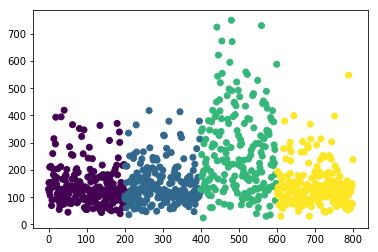

mean
145.816480093
149.576911608
272.160074613
134.968334017
median
126.253673316
127.992951699
235.899431081
118.998364223
standard deviation
76.2233013185
85.5665510222
160.456838113
72.3337654939


In [32]:
X_std = np.std(X_train, axis=1)
print(X_std.shape)
plt.scatter(x=range(X_std[ind_plot].shape[0]),
            y=X_std[ind_plot], c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_std[np.where(y_train==i)]))
print('median')
for i in range(4):
    print(np.median(X_std[np.where(y_train==i)]))
print('standard deviation')
for i in range(4):
    print(np.std(X_std[np.where(y_train==i)]))

Variance of the signal

(6822,)


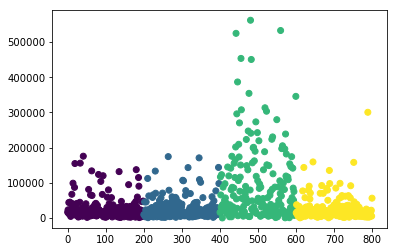

mean
27072.4375307
29694.88714
99817.5031105
23448.624818
median
15939.9936221
16382.1956846
55648.5415841
14160.6201382
standard deviation
34432.4471787
49180.2646456
115003.027226
40146.6440267


In [33]:
X_var = np.var(X_train, axis=1)
print(X_var.shape)
plt.scatter(x=range(X_var[ind_plot].shape[0]),
            y=X_var[ind_plot], c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_var[np.where(y_train==i)]))
print('median')
for i in range(4):
    print(np.median(X_var[np.where(y_train==i)]))
print('standard deviation')
for i in range(4):
    print(np.std(X_var[np.where(y_train==i)]))

Boolean variable indicating if the tail of the signal is equal to 0 or not

(6822,)


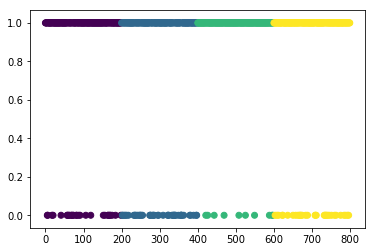

mean
0.855198019802
0.775063613232
0.929515418502
0.840677966102
median
1.0
1.0
1.0
1.0
standard deviation
0.351901075203
0.417540427595
0.255961921521
0.365976124102


In [37]:
X_null_tail = np.array([np.all(X_train[i, 10000:10010]==0) for i in range(X_train.shape[0])])
print(X_null_tail.shape)
plt.scatter(x=range(X_null_tail[ind_plot].shape[0]), y=X_null_tail[ind_plot], c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_null_tail[np.where(y_train==i)]))
print('median')
for i in range(4):
    print(np.median(X_null_tail[np.where(y_train==i)]))
print('standard deviation')
for i in range(4):
    print(np.std(X_null_tail[np.where(y_train==i)]))

Log of the square of the sum and square of the sum

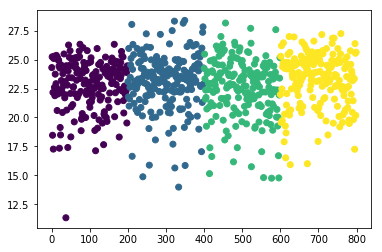

mean
22.7143924367
23.2056977778
22.5597638118
23.0972636257
median
23.1567614402
23.555082079
22.8301400976
23.5391931521
standard deviation
2.29146618007
2.39343947277
2.55846611528
2.39872465687


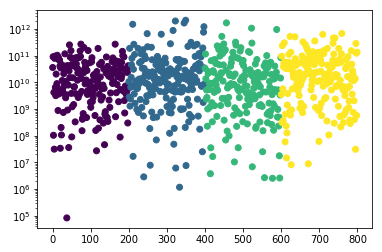

mean
32615842581.1
106000104116.0
71344992750.2
57991956479.2
median
11398659216.5
16976265849.0
8222499684.0
16708666493.0
standard deviation
88776927488.5
1.36040973213e+12
270470300119.0
146751123172.0


In [35]:
X_sum = np.sum(X_train, axis=1)
X_log_sq_sum = np.log(X_sum**2)

plt.scatter(x=range(X_log_sq_sum[ind_plot].shape[0]), y=X_log_sq_sum[ind_plot], c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_log_sq_sum[np.where(y_train==i)]))
print('median')
for i in range(4):
    print(np.median(X_log_sq_sum[np.where(y_train==i)]))
print('standard deviation')
for i in range(4):
    print(np.std(X_log_sq_sum[np.where(y_train==i)]))
    
X_sum = np.sum(X_train, axis=1)
X_sq_sum = X_sum**2
fig = plt.figure()
ax = plt.gca()
ax.scatter(x=range(X_sq_sum[ind_plot].shape[0]), y=X_sq_sum[ind_plot], c=y_train[ind_plot])
ax.set_yscale('log')
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_sq_sum[np.where(y_train==i)]))
print('median')
for i in range(4):
    print(np.median(X_sq_sum[np.where(y_train==i)]))
print('standard deviation')
for i in range(4):
    print(np.std(X_sq_sum[np.where(y_train==i)]))

Maximum of the absolute value of the signal

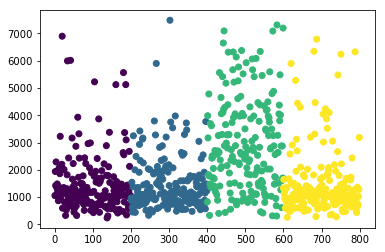

mean
1527.04876238
1482.36284987
2962.91629956
1341.06440678
median
1179.0
1146.0
2652.0
1054.5
standard deviation
1131.94561293
1121.27765191
1676.1199759
974.342581969


In [26]:
X_abs = np.absolute(X_train)
X_max_abs = np.max(X_abs, axis=1)
plt.scatter(x=range(X_max_abs[ind_plot].shape[0]), y=X_max_abs[ind_plot], c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_max_abs[np.where(y_train==i)]))
print('median')
for i in range(4):
    print(np.median(X_max_abs[np.where(y_train==i)]))
print('standard deviation')
for i in range(4):
    print(np.std(X_max_abs[np.where(y_train==i)]))

Maximum and minimum of the signal

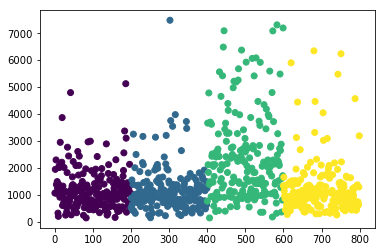

mean
1288.24554455
1244.70737913
2420.74008811
1115.73898305
median
1053.5
1012.0
2071.0
933.5
standard deviation
974.476009796
960.958969912
1620.28437661
795.591275488


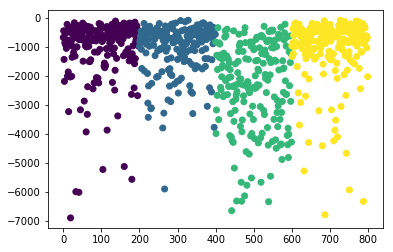

mean
-1061.46584158
-1028.64681934
-2370.44052863
-957.627118644
median
-729.0
-707.0
-2156.0
-661.5
standard deviation
1027.84554009
1008.82538426
1495.0343475
953.170024108


In [29]:
X_max = np.max(X_train, axis=1)
X_min = np.min(X_train, axis=1)

plt.scatter(x=range(X_max[ind_plot].shape[0]), y=X_max[ind_plot], c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_max[np.where(y_train==i)]))
print('median')
for i in range(4):
    print(np.median(X_max[np.where(y_train==i)]))
print('standard deviation')
for i in range(4):
    print(np.std(X_max[np.where(y_train==i)]))
    
plt.scatter(x=range(X_min[ind_plot].shape[0]), y=X_min[ind_plot], c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_min[np.where(y_train==i)]))
print('median')
for i in range(4):
    print(np.median(X_min[np.where(y_train==i)]))
print('standard deviation')
for i in range(4):
    print(np.std(X_min[np.where(y_train==i)]))

A first attempt to quantify the frequency of the heart beats

In [222]:
X_nb_per = np.array([sum(((X_train[i] <= 600) & (500 <= X_train[i]))) for i in range(X_train.shape[0])])

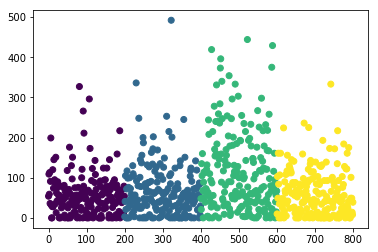

mean
57.499009901
69.8743002545
120.731277533
63.6372881356
median
48.0
52.0
95.0
51.0
standard deviation
54.793383273
81.4640648924
105.761818013
59.1314877784


In [223]:
plt.scatter(x=range(X_nb_per[ind_plot].shape[0]), y=X_nb_per[ind_plot], c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_nb_per[np.where(y_train==i)]))
print('median')
for i in range(4):
    print(np.median(X_nb_per[np.where(y_train==i)]))
print('standard deviation')
for i in range(4):
    print(np.std(X_nb_per[np.where(y_train==i)]))

In [37]:
A = np.zeros(12).reshape(4, 3)
A[0, 1] =10
A[0, 2] = -5
A[1, 0] = -3
print(A)
print(np.array([(max(A[i])>=-min(A[i])) for i in range(A.shape[0])]))

[[  0.  10.  -5.]
 [ -3.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]]
[ True False  True  True]


Boolean variable indicating if the maximum is bigger than the minimum.

In [34]:
X_max_or_min = np.array([(max(X_train[i][1000:])>=-min(X_train[i][1000:])) for i in range(X_train.shape[0])])

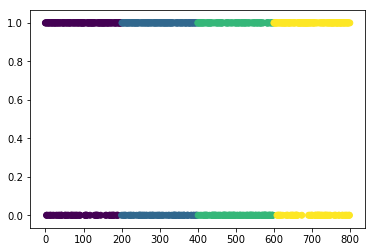

mean
0.72004950495
0.705852417303
0.52422907489
0.706779661017
median
1.0
1.0
1.0
1.0
standard deviation
0.448974626645
0.45565862473
0.499412606899
0.455238587764


In [35]:
plt.scatter(x=range(X_max_or_min[ind_plot].shape[0]), y=X_max_or_min[ind_plot], c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_max_or_min[np.where(y_train==i)]))
print('median')
for i in range(4):
    print(np.median(X_max_or_min[np.where(y_train==i)]))
print('standard deviation')
for i in range(4):
    print(np.std(X_max_or_min[np.where(y_train==i)]))

X_max_or_min[i*10] =  True
y =  0.0


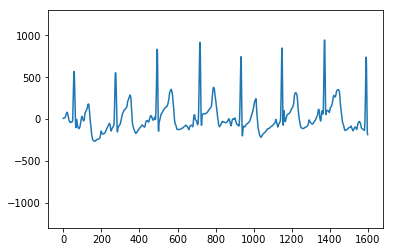

X_max_or_min[i*10] =  True
y =  0.0


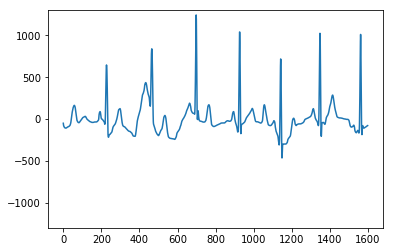

X_max_or_min[i*10] =  False
y =  0.0


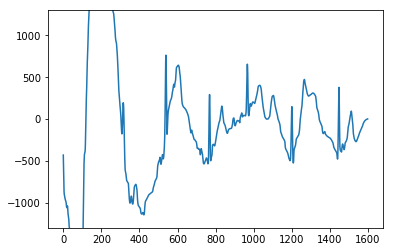

X_max_or_min[i*10] =  True
y =  0.0


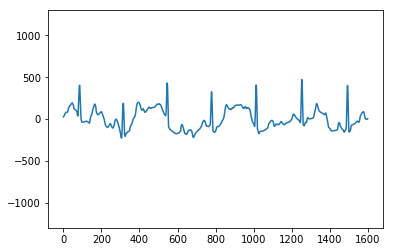

X_max_or_min[i*10] =  True
y =  0.0


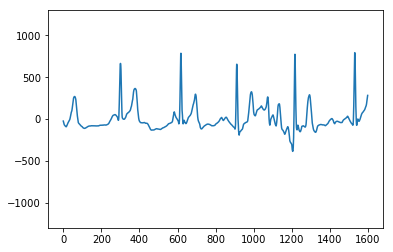

X_max_or_min[i*10] =  True
y =  3.0


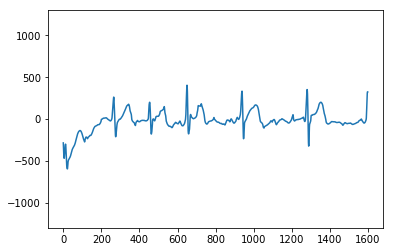

X_max_or_min[i*10] =  False
y =  0.0


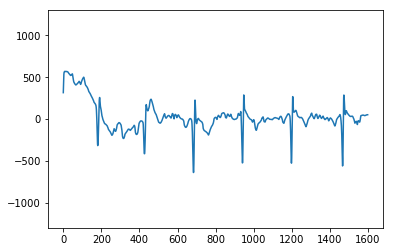

X_max_or_min[i*10] =  True
y =  0.0


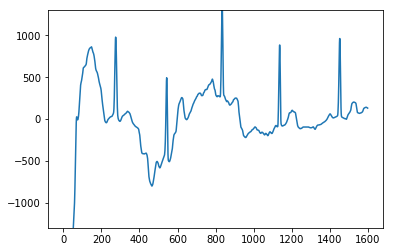

X_max_or_min[i*10] =  True
y =  1.0


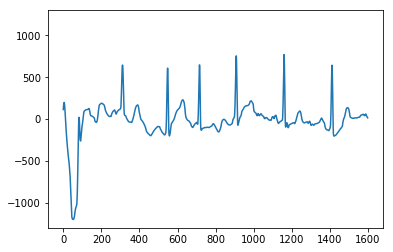

X_max_or_min[i*10] =  True
y =  0.0


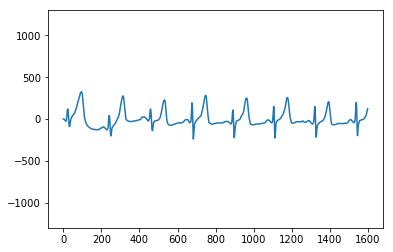

X_max_or_min[i*10] =  True
y =  0.0


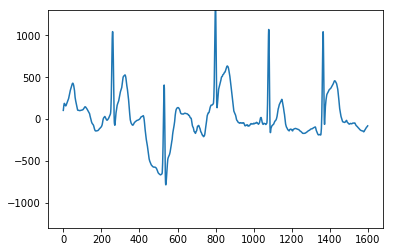

X_max_or_min[i*10] =  True
y =  1.0


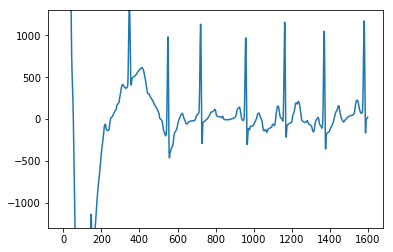

X_max_or_min[i*10] =  True
y =  3.0


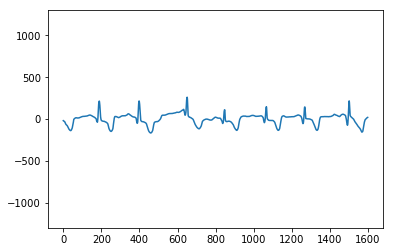

X_max_or_min[i*10] =  False
y =  0.0


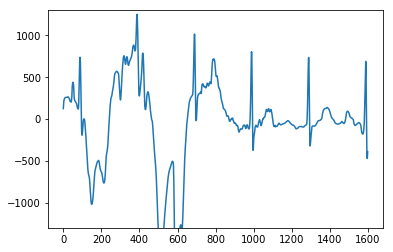

X_max_or_min[i*10] =  True
y =  2.0


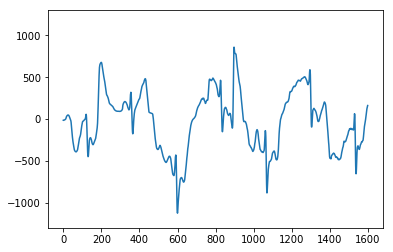

X_max_or_min[i*10] =  True
y =  1.0


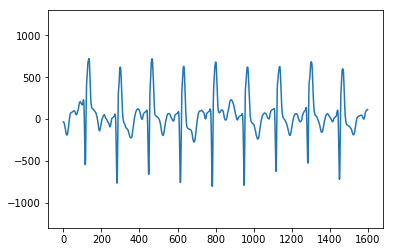

X_max_or_min[i*10] =  True
y =  0.0


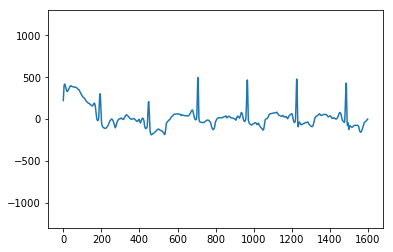

X_max_or_min[i*10] =  True
y =  0.0


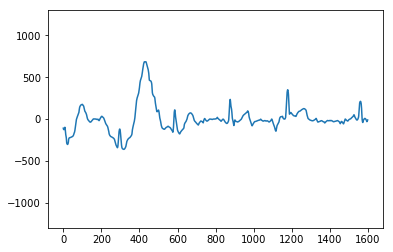

X_max_or_min[i*10] =  True
y =  3.0


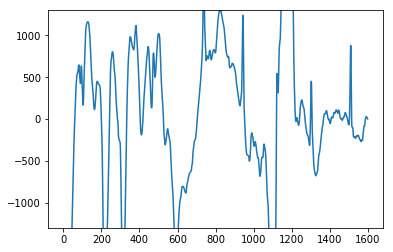

X_max_or_min[i*10] =  True
y =  0.0


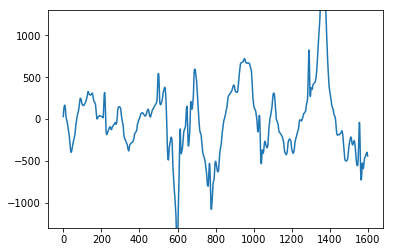

X_max_or_min[i*10] =  True
y =  1.0


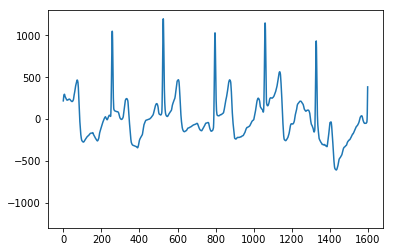

X_max_or_min[i*10] =  True
y =  0.0


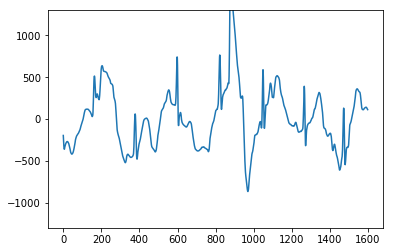

X_max_or_min[i*10] =  True
y =  0.0


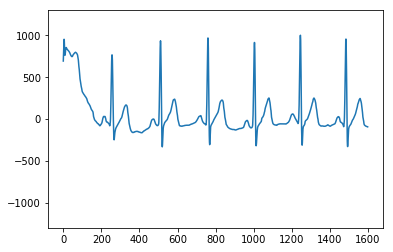

X_max_or_min[i*10] =  True
y =  0.0


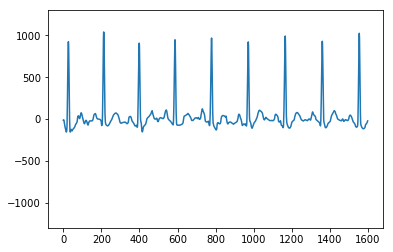

X_max_or_min[i*10] =  True
y =  0.0


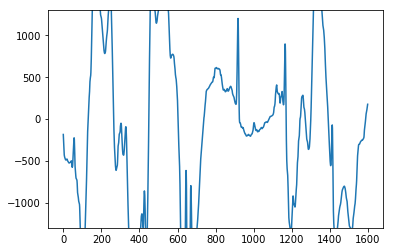

X_max_or_min[i*10] =  True
y =  0.0


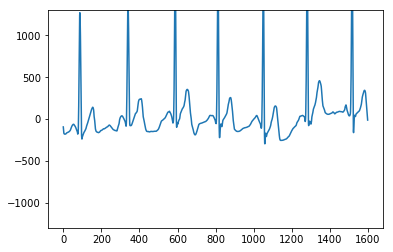

X_max_or_min[i*10] =  True
y =  0.0


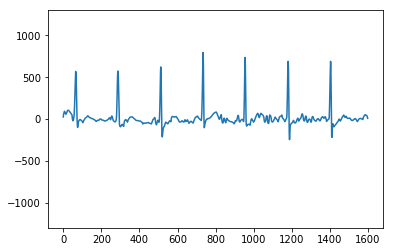

X_max_or_min[i*10] =  True
y =  0.0


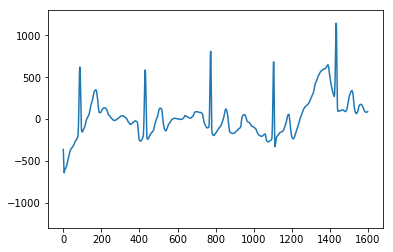

X_max_or_min[i*10] =  False
y =  1.0


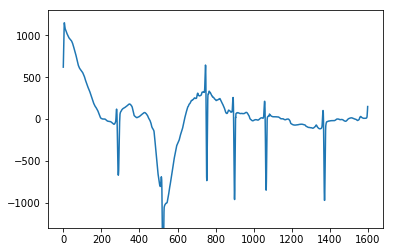

X_max_or_min[i*10] =  True
y =  1.0


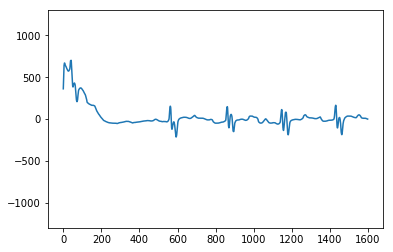

X_max_or_min[i*10] =  True
y =  0.0


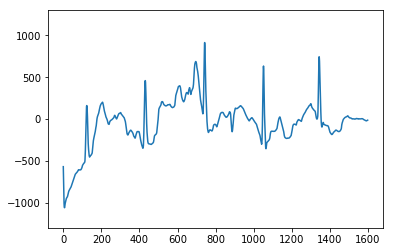

X_max_or_min[i*10] =  True
y =  3.0


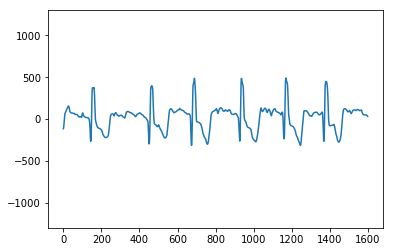

X_max_or_min[i*10] =  True
y =  0.0


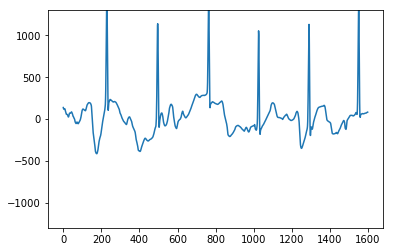

X_max_or_min[i*10] =  False
y =  0.0


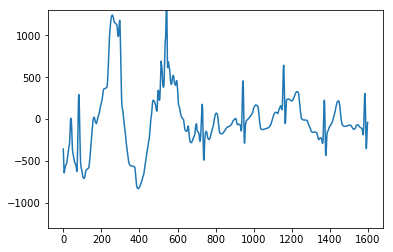

X_max_or_min[i*10] =  True
y =  0.0


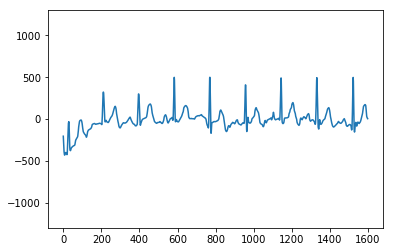

X_max_or_min[i*10] =  True
y =  1.0


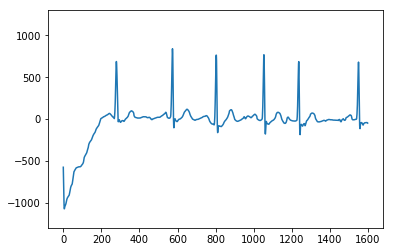

X_max_or_min[i*10] =  False
y =  0.0


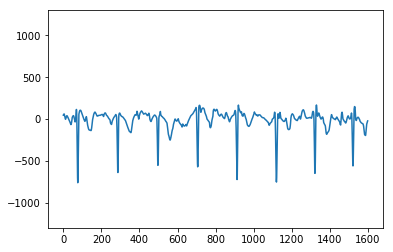

X_max_or_min[i*10] =  True
y =  0.0


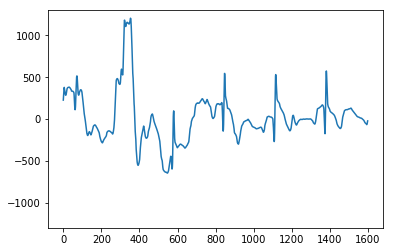

X_max_or_min[i*10] =  True
y =  0.0


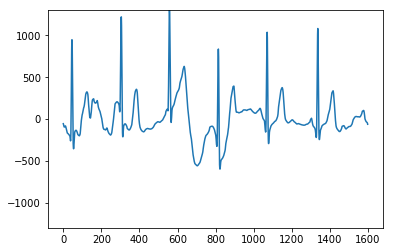

X_max_or_min[i*10] =  True
y =  0.0


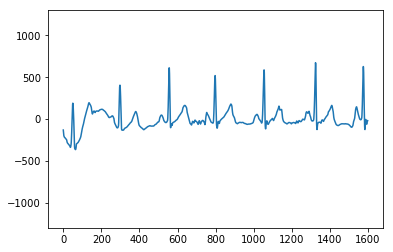

X_max_or_min[i*10] =  True
y =  0.0


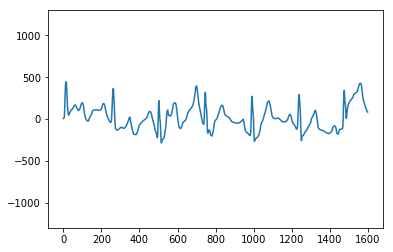

X_max_or_min[i*10] =  True
y =  0.0


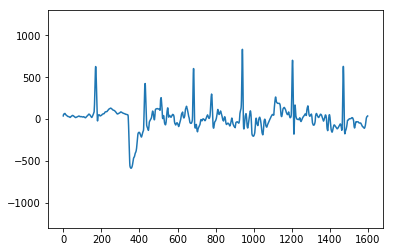

X_max_or_min[i*10] =  False
y =  3.0


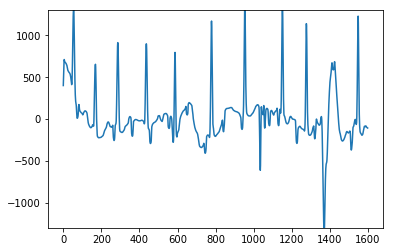

X_max_or_min[i*10] =  False
y =  1.0


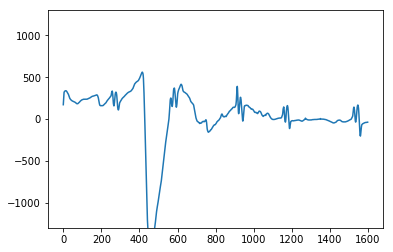

X_max_or_min[i*10] =  True
y =  1.0


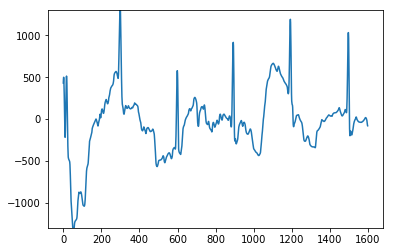

X_max_or_min[i*10] =  True
y =  1.0


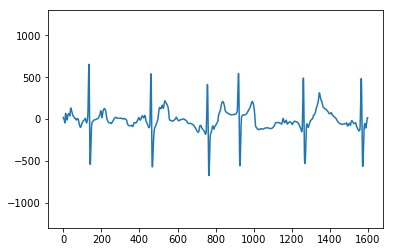

X_max_or_min[i*10] =  False
y =  0.0


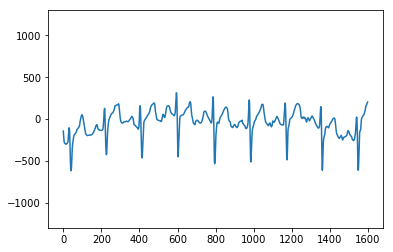

X_max_or_min[i*10] =  False
y =  0.0


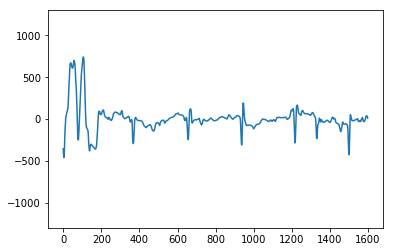

X_max_or_min[i*10] =  True
y =  1.0


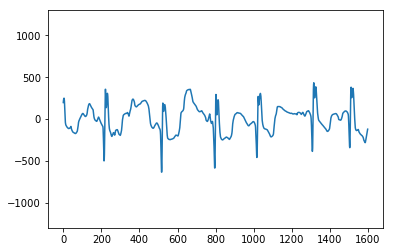

X_max_or_min[i*10] =  True
y =  0.0


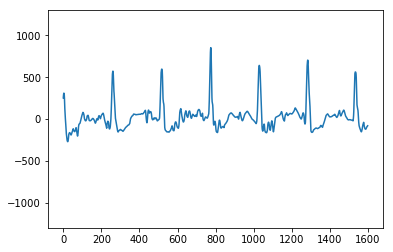

X_max_or_min[i*10] =  False
y =  3.0


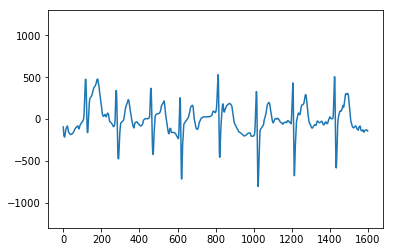

X_max_or_min[i*10] =  True
y =  0.0


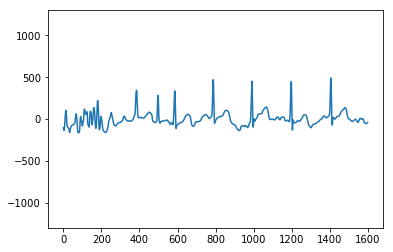

X_max_or_min[i*10] =  True
y =  3.0


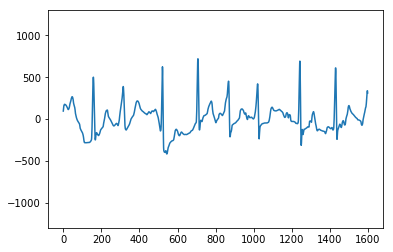

X_max_or_min[i*10] =  False
y =  0.0


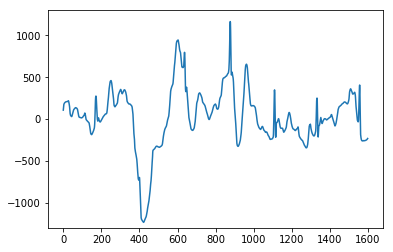

X_max_or_min[i*10] =  False
y =  3.0


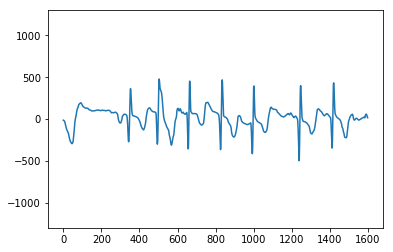

X_max_or_min[i*10] =  False
y =  0.0


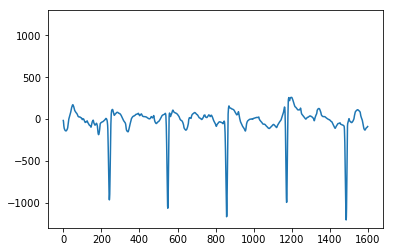

X_max_or_min[i*10] =  False
y =  0.0


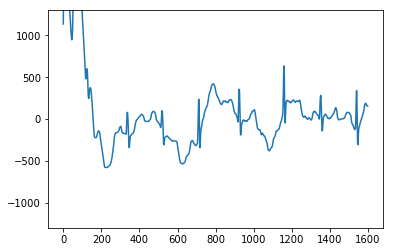

X_max_or_min[i*10] =  True
y =  0.0


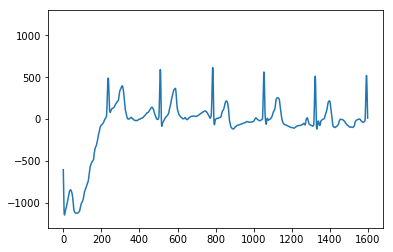

X_max_or_min[i*10] =  True
y =  0.0


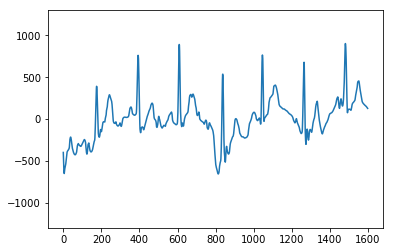

X_max_or_min[i*10] =  True
y =  1.0


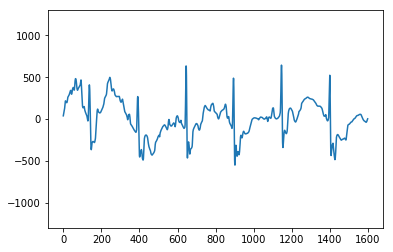

X_max_or_min[i*10] =  True
y =  0.0


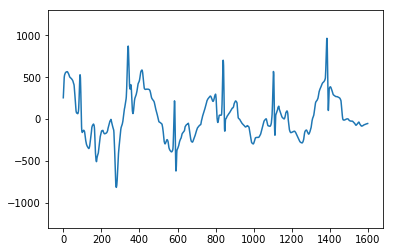

X_max_or_min[i*10] =  True
y =  0.0


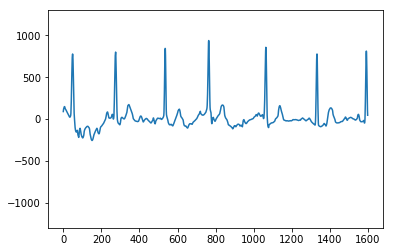

X_max_or_min[i*10] =  True
y =  2.0


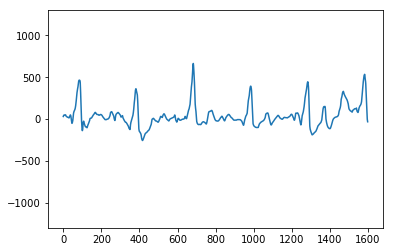

X_max_or_min[i*10] =  True
y =  0.0


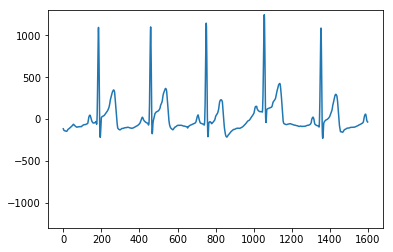

X_max_or_min[i*10] =  True
y =  0.0


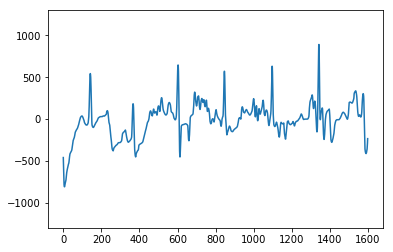

X_max_or_min[i*10] =  True
y =  0.0


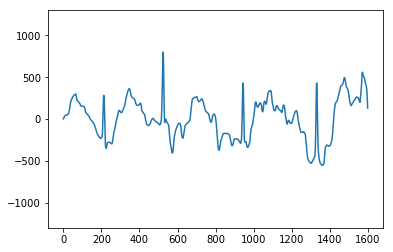

X_max_or_min[i*10] =  True
y =  0.0


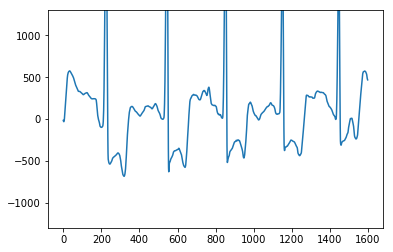

X_max_or_min[i*10] =  True
y =  1.0


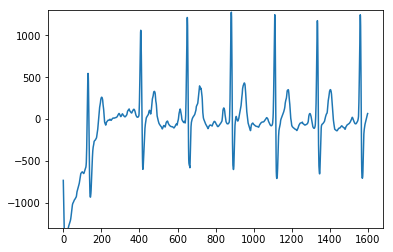

X_max_or_min[i*10] =  True
y =  0.0


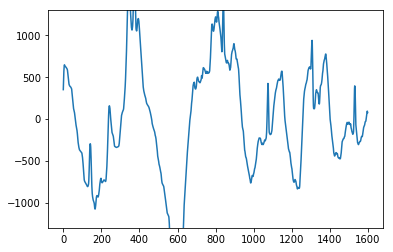

X_max_or_min[i*10] =  True
y =  1.0


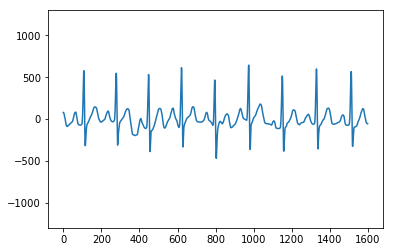

X_max_or_min[i*10] =  False
y =  0.0


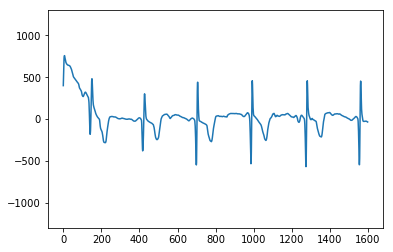

X_max_or_min[i*10] =  True
y =  2.0


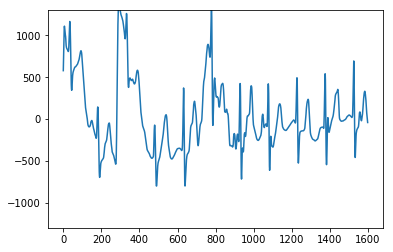

X_max_or_min[i*10] =  True
y =  0.0


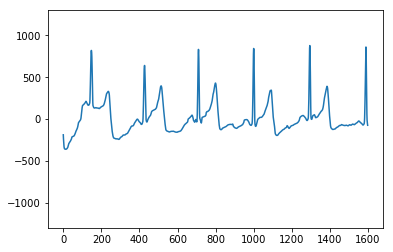

X_max_or_min[i*10] =  False
y =  3.0


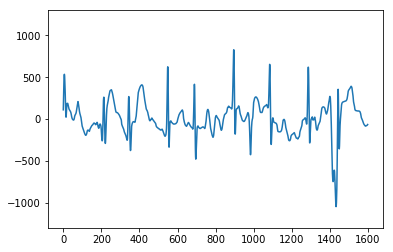

X_max_or_min[i*10] =  False
y =  1.0


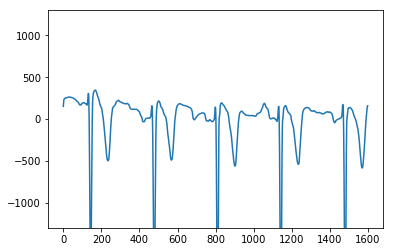

X_max_or_min[i*10] =  True
y =  1.0


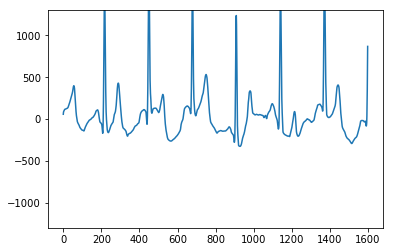

X_max_or_min[i*10] =  False
y =  0.0


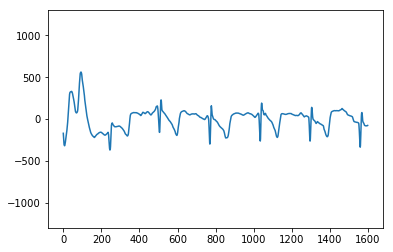

X_max_or_min[i*10] =  True
y =  1.0


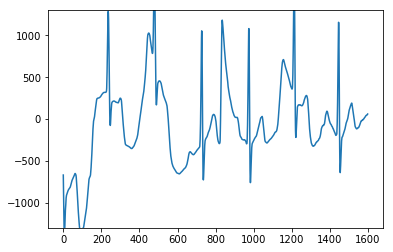

X_max_or_min[i*10] =  True
y =  1.0


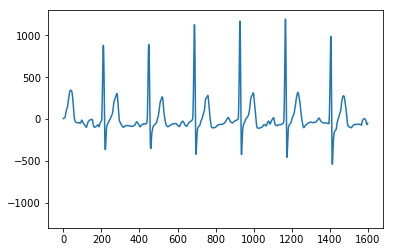

X_max_or_min[i*10] =  True
y =  0.0


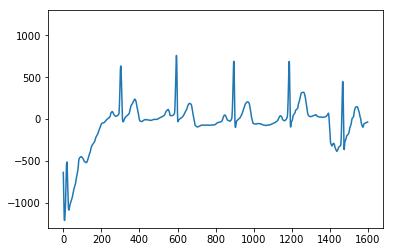

X_max_or_min[i*10] =  True
y =  0.0


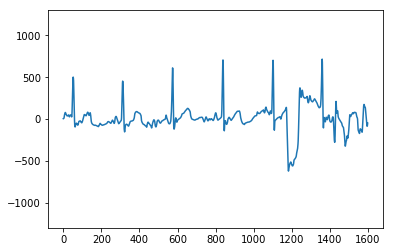

X_max_or_min[i*10] =  True
y =  3.0


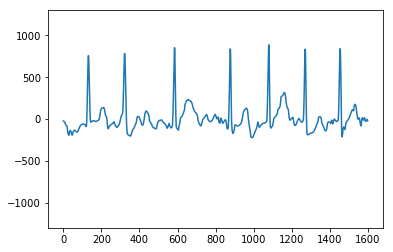

X_max_or_min[i*10] =  True
y =  1.0


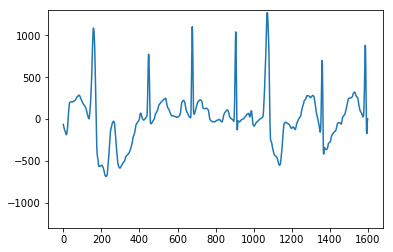

X_max_or_min[i*10] =  True
y =  0.0


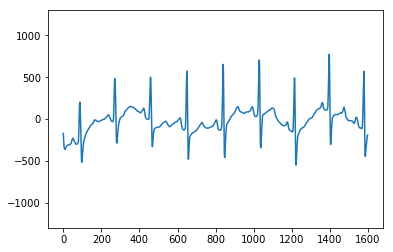

X_max_or_min[i*10] =  True
y =  0.0


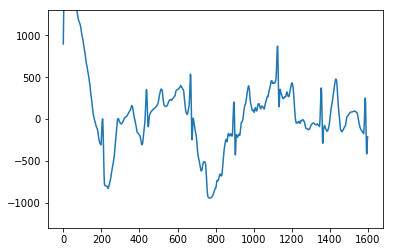

X_max_or_min[i*10] =  True
y =  0.0


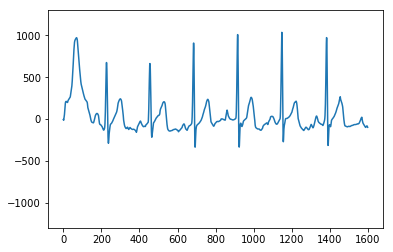

X_max_or_min[i*10] =  False
y =  0.0


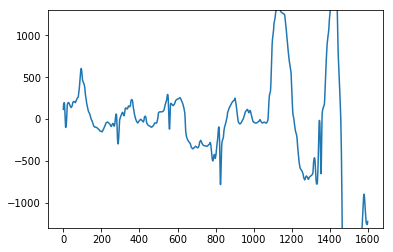

X_max_or_min[i*10] =  True
y =  1.0


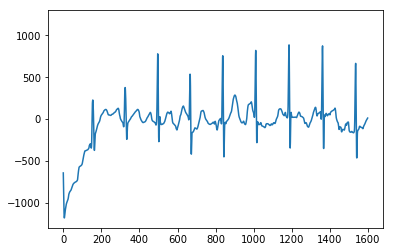

X_max_or_min[i*10] =  False
y =  0.0


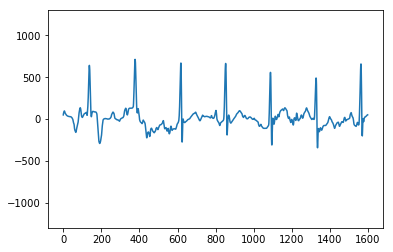

X_max_or_min[i*10] =  True
y =  0.0


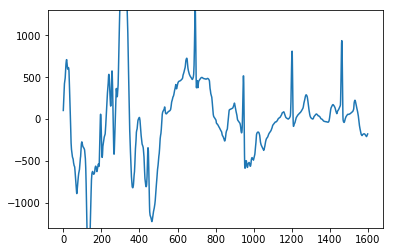

X_max_or_min[i*10] =  False
y =  0.0


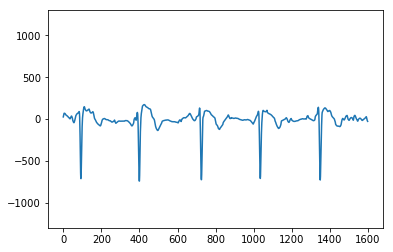

X_max_or_min[i*10] =  True
y =  1.0


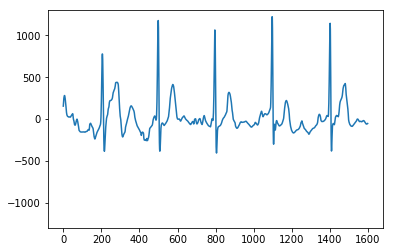

X_max_or_min[i*10] =  False
y =  0.0


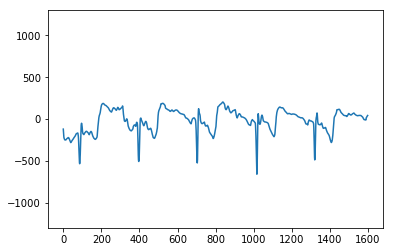

X_max_or_min[i*10] =  True
y =  1.0


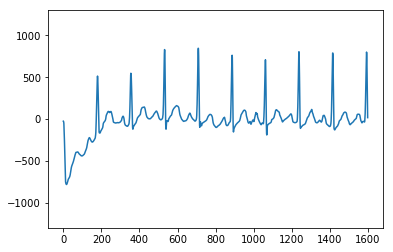

X_max_or_min[i*10] =  True
y =  0.0


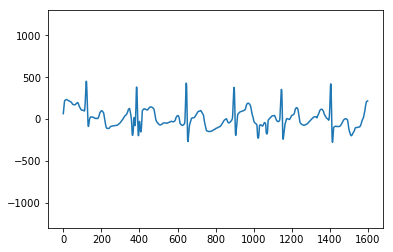

X_max_or_min[i*10] =  True
y =  0.0


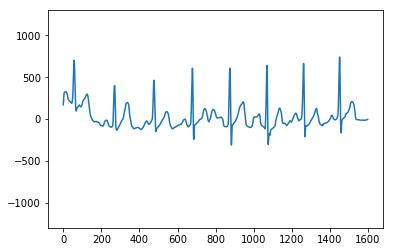

X_max_or_min[i*10] =  True
y =  0.0


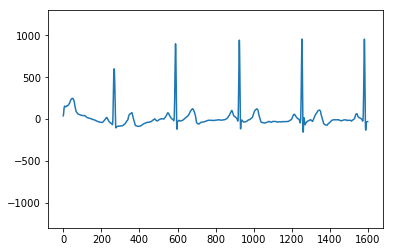

X_max_or_min[i*10] =  False
y =  1.0


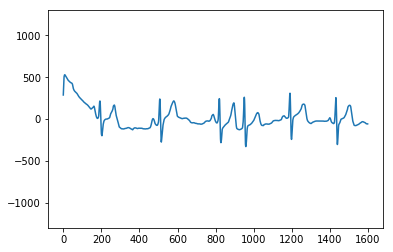

X_max_or_min[i*10] =  False
y =  1.0


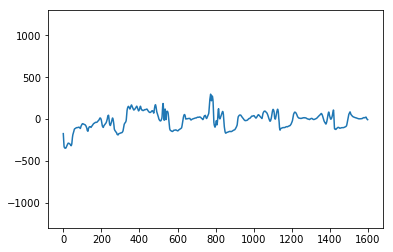

X_max_or_min[i*10] =  True
y =  0.0


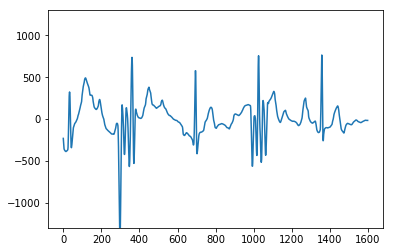

In [36]:
ymin = -1300
ymax = 1300
for i in range(100):
    axes = plt.gca()
    axes.set_ylim([ymin,ymax])
    print('X_max_or_min[i*10] = ', X_max_or_min[i*10])
    print('y = ', y_train[i*10])
    plt.plot(X_train[i*10][:1600])
    plt.show()

In [66]:
A = np.arange(12).reshape(3, 4)
print(A)
B = np.maximum(2*A, np.ones(shape=[3, 4]))
print(B)
print(A/B)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[  1.   2.   4.   6.]
 [  8.  10.  12.  14.]
 [ 16.  18.  20.  22.]]
[[ 0.   0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5]]


In the next cell I divide each signal into several intervals to look at them more locally.

In [120]:
n_samp = 20
X = X_train[ind_plot, 1000:9000]
wind = 500
n_wind = int(X.shape[1]/wind)
X_max_abs_s = np.zeros(shape=(X.shape[0], n_wind))
X_max_s = np.zeros(shape=(X.shape[0], n_wind))
X_min_s = np.ones(shape=(X.shape[0], n_wind))
frac_max = 0.6
frac_sma = 0.2
X_n_peaks = np.zeros(shape=(X.shape[0], n_wind))
X_n_small = np.zeros(shape=(X.shape[0], n_wind))
for i in range(n_wind):
    X_max_abs_s[:, i] = np.max(np.abs(X[:, i*wind:(i+1)*wind]), axis=1)
    X_max_s[:, i] = np.max(X[:, i*wind:(i+1)*wind], axis=1)
    X_min_s[:, i] = np.minimum(np.min(X[:, i*wind:(i+1)*wind], axis=1), -X_min_s[:, i] ) # to avoid division by 0
    X_n_peaks[:, i] = np.sum(
        (np.abs(X[:, i*wind:(i+1)*wind]) > frac_max*X_max_abs_s[:, i].reshape(X.shape[0],1)), axis=1)
    X_n_small[:, i] = np.sum(
        (np.abs(X[:, i*wind:(i+1)*wind]) < frac_sma*X_max_abs_s[:, i].reshape(X.shape[0],1)), axis=1)
    
X_n_peaks_mean = np.mean(X_n_peaks, axis=1)
X_n_peaks_std = np.std(X_n_peaks, axis=1)
X_n_small_mean = np.mean(X_n_small, axis=1)
X_n_small_std = np.std(X_n_small, axis=1)

X_f_max_mmin = X_max_s/(-X_min_s)
X_f_max_mmin_mean = np.mean(X_f_max_mmin, axis=1)
X_f_max_mmin_std = np.std(X_f_max_mmin, axis=1)

Index #  0
Maximum absolute value
[  944.   797.   861.   880.   904.   790.   899.   954.   895.   945.
   908.   866.   900.   895.  1058.  1009.]
Mean of number of peaks pro period =  13.75
Std of number of peaks pro period =  3.23071199583
Number of peaks
[ 12.  11.  18.  11.  14.  19.  11.  16.  13.  17.  10.  12.  15.  11.  20.
  10.]
0.6 max first period =  566.4


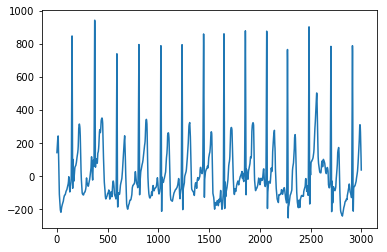

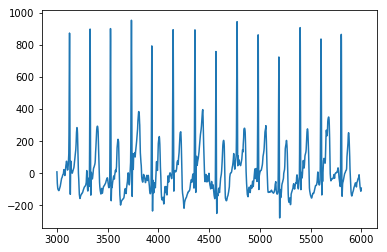

Index #  1
Maximum absolute value
[  790.   816.   673.   924.   836.  1402.  1150.   824.   840.  1709.
   666.   856.   813.   810.   700.   902.]
Mean of number of peaks pro period =  14.3125
Std of number of peaks pro period =  5.88131309743
Number of peaks
[ 14.  13.  13.  31.  10.  23.   8.  13.  14.  20.  17.  11.   6.  12.  12.
  12.]
0.6 max first period =  474.0


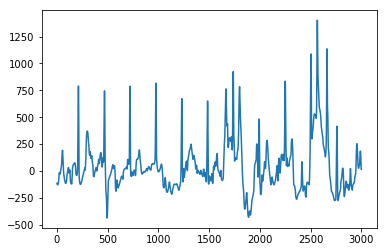

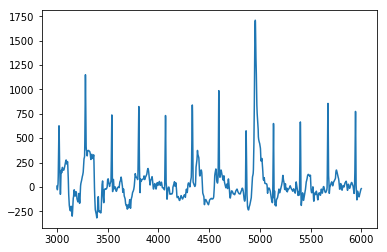

Index #  2
Maximum absolute value
[  747.   728.   697.   661.   728.   713.   673.   701.   671.   904.
  1067.   936.   713.   569.   526.   578.]
Mean of number of peaks pro period =  18.0
Std of number of peaks pro period =  12.7524507449
Number of peaks
[ 13.  12.   7.  22.   6.  13.   7.  13.   7.  15.  21.  53.  40.  12.  32.
  15.]
0.6 max first period =  448.2


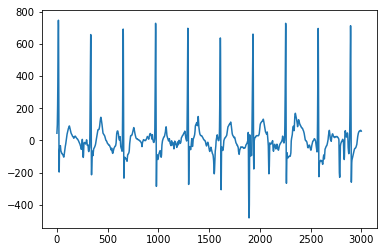

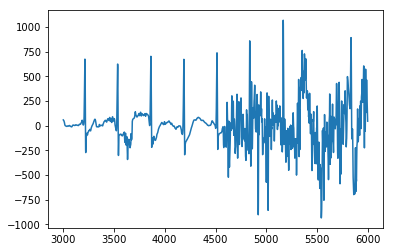

Index #  6
Maximum absolute value
[ 1001.   766.   795.   712.   749.   765.   684.  2182.  1082.   797.
   624.   752.   742.   733.   692.   748.]
Mean of number of peaks pro period =  23.5
Std of number of peaks pro period =  6.0415229868
Number of peaks
[ 27.  24.  20.  18.  25.  23.  20.  42.  17.  23.  20.  27.  27.  18.  28.
  17.]
0.6 max first period =  600.6


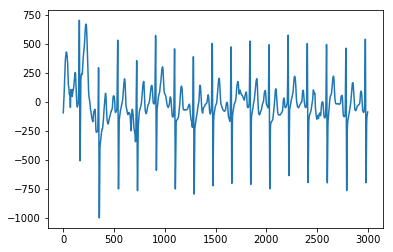

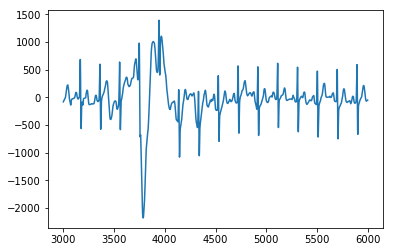

Index #  7
Maximum absolute value
[ 851.  535.  369.  286.  321.  262.  277.  270.  277.  251.  291.  245.
  252.  270.  249.  337.]
Mean of number of peaks pro period =  30.0625
Std of number of peaks pro period =  25.9385541954
Number of peaks
[ 93.  15.  17.  16.  16.  45.  95.  12.  18.  38.  21.  19.  10.  19.  34.
  13.]
0.6 max first period =  510.6


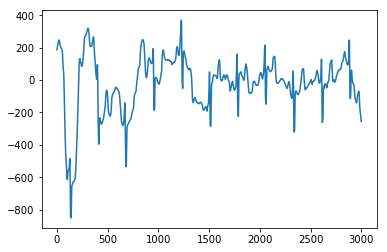

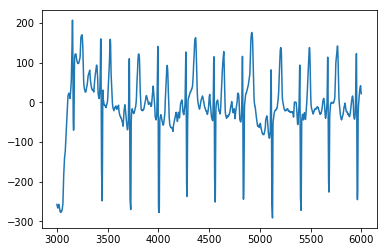

Index #  8
Maximum absolute value
[  782.   858.   741.   845.  1046.   894.   881.   910.   868.   983.
   920.   914.   854.   889.  1049.   937.]
Mean of number of peaks pro period =  12.0625
Std of number of peaks pro period =  2.7264617639
Number of peaks
[ 17.  12.  11.  12.   9.  15.  11.  11.  18.  10.  10.  11.  16.  10.  10.
  10.]
0.6 max first period =  469.2


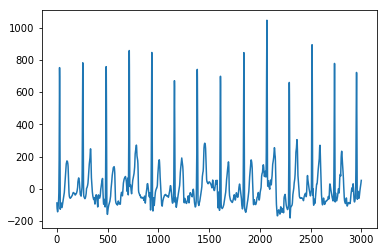

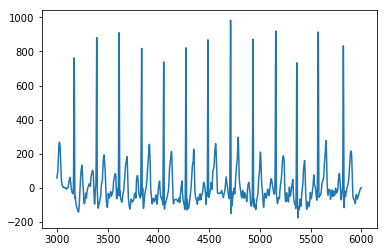

Index #  9
Maximum absolute value
[  989.   831.   937.   684.   925.  1125.   663.   743.   890.   895.
   886.   632.   949.   893.  1114.   770.]
Mean of number of peaks pro period =  24.5625
Std of number of peaks pro period =  28.2687299635
Number of peaks
[ 108.    7.   44.    6.   13.   11.    6.   11.   11.   12.   13.    6.
   10.   19.   40.   76.]
0.6 max first period =  593.4


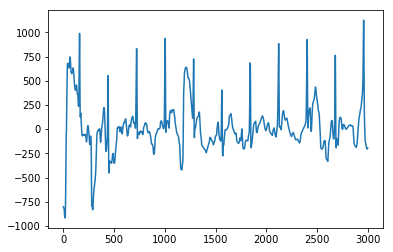

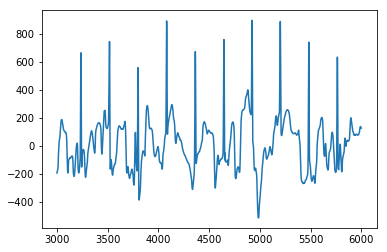

Index #  10
Maximum absolute value
[ 1025.  1213.  1094.   931.  1187.  1055.   967.   989.  1030.  1143.
  1147.   944.   960.  1065.  1068.  1136.]
Mean of number of peaks pro period =  11.5625
Std of number of peaks pro period =  2.73789951423
Number of peaks
[  8.   9.  14.   9.  10.  16.   9.  10.  15.   8.  15.  12.  10.  14.  11.
  15.]
0.6 max first period =  615.0


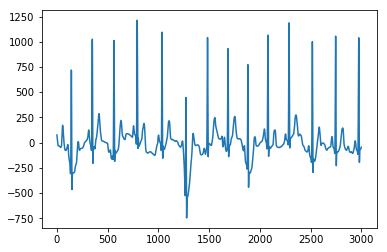

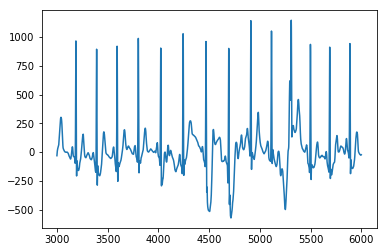

Index #  11
Maximum absolute value
[ 297.  221.  279.  249.  279.  312.  232.  241.  292.  262.  265.  225.
  237.  297.  222.  248.]
Mean of number of peaks pro period =  10.625
Std of number of peaks pro period =  2.93417364858
Number of peaks
[ 11.  14.  10.   5.  10.  11.  15.   6.  11.  14.   7.  15.  12.  10.   8.
  11.]
0.6 max first period =  178.2


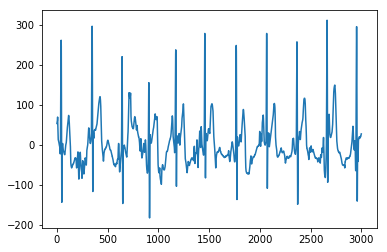

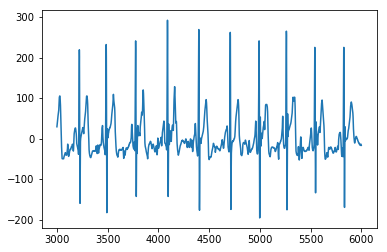

Index #  12
Maximum absolute value
[ 747.  834.  800.  829.  829.  777.  760.  770.  781.  766.  709.  687.
  704.  798.  867.  741.]
Mean of number of peaks pro period =  8.4375
Std of number of peaks pro period =  2.57314860628
Number of peaks
[  6.  11.   6.   9.   8.   6.  12.   6.  10.   7.  13.   6.  12.   6.   6.
  11.]
0.6 max first period =  448.2


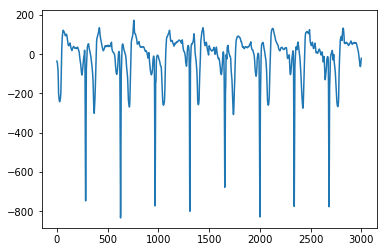

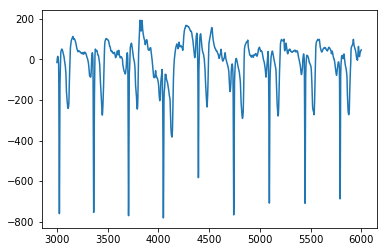

In [44]:
for i in range(10):
    print('Index # ', ind_plot[i])
    print('Maximum absolute value')
    print(X_max_abs_s[i])
    print('Mean of number of peaks pro period = ', X_n_peaks_mean[i])
    print('Std of number of peaks pro period = ', X_n_peaks_std[i])
    print('Number of peaks')
    print(X_n_peaks[i])
    print('0.6 max first period = ', 0.6*X_max_abs_s[i, 0])
    #print('First 500 entries of the signal')
    #print(X[i, :500])
    plt.plot(range(3000), X[i, :3000])
    plt.show()
    plt.plot(range(3000, 6000), X[i, 3000:6000])
    plt.show()

X_n_peaks_mean

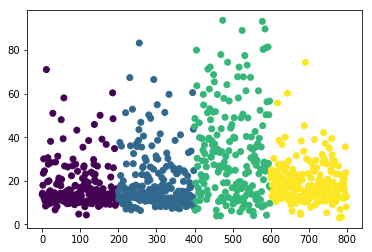

mean
17.4946875
20.235
32.6646875
19.555625
median
13.625
15.28125
28.28125
17.46875
standard deviation
10.4399150976
12.9671674336
21.2122911539
9.54226983856


In [42]:
plt.scatter(x=range(X_n_peaks_mean.shape[0]), y=X_n_peaks_mean, c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_n_peaks_mean[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))
print('median')
for i in range(4):
    print(np.median(X_n_peaks_mean[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))
print('standard deviation')
for i in range(4):
    print(np.std(X_n_peaks_mean[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))

X_n_peaks_std

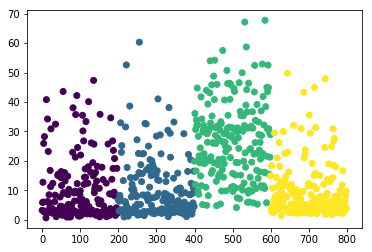

mean
9.55129183964
9.70595476231
26.6406284773
9.43090211891
median
4.6006376256
5.87731514057
26.324408309
5.97112540347
standard deviation
10.3067499109
9.83024215887
13.2198381748
9.00153194801


In [82]:
plt.scatter(x=range(X_n_peaks_std.shape[0]), y=X_n_peaks_std, c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_n_peaks_std[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))
print('median')
for i in range(4):
    print(np.median(X_n_peaks_std[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))
print('standard deviation')
for i in range(4):
    print(np.std(X_n_peaks_std[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))

X_n_small_mean

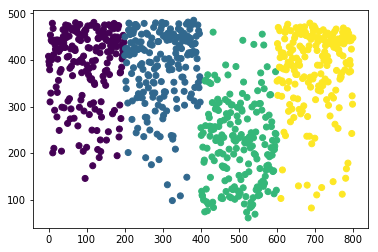

mean
386.6765625
383.4840625
220.6965625
378.870625
median
416.21875
407.125
222.375
403.40625
standard deviation
80.4620223978
81.4849839976
88.8498306039
87.5936968226


In [45]:
plt.scatter(x=range(X_n_small_mean.shape[0]), y=X_n_small_mean, c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_n_small_mean[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))
print('median')
for i in range(4):
    print(np.median(X_n_small_mean[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))
print('standard deviation')
for i in range(4):
    print(np.std(X_n_small_mean[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))

X_n_small_std

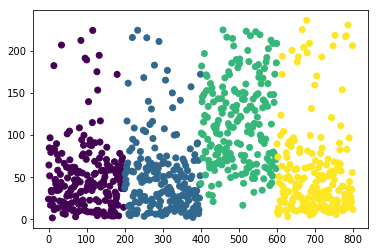

mean
50.8253295421
51.3499634664
113.894890446
56.5987688037
median
42.0222837481
40.3368865358
109.955096837
36.7234098325
standard deviation
42.1204763657
45.2972157633
50.5550852548
55.2457863458


In [46]:
plt.scatter(x=range(X_n_small_std.shape[0]), y=X_n_small_std, c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_n_small_std[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))
print('median')
for i in range(4):
    print(np.median(X_n_small_std[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))
print('standard deviation')
for i in range(4):
    print(np.std(X_n_small_std[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))

X_f_max_mmin_mean

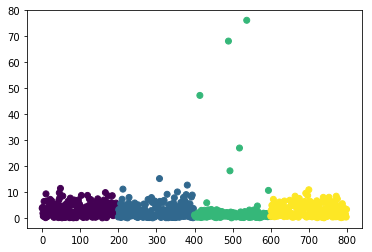

mean
3.28369579941
2.90756060104
2.44272038427
2.8937401924
median
2.78311038248
2.19679007916
1.10514488042
2.08074123288
standard deviation
2.34920163922
2.53507667417
8.08593164106
2.28097289492


In [121]:
plt.scatter(x=range(X_f_max_mmin_mean.shape[0]), y=X_f_max_mmin_mean, c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_f_max_mmin_mean[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))
print('median')
for i in range(4):
    print(np.median(X_f_max_mmin_mean[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))
print('standard deviation')
for i in range(4):
    print(np.std(X_f_max_mmin_mean[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))

X_f_max_mmin_std

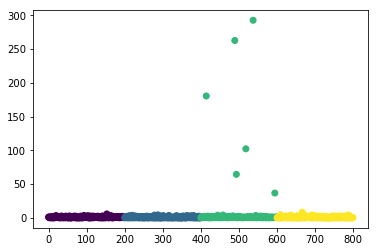

mean
1.0776220331
0.978457551286
5.69037499645
1.10143620095
median
0.882251955258
0.679798152704
0.828721147739
0.745836462223
standard deviation
0.884286547872
0.953225807177
31.3720536006
1.1327630443


In [122]:
plt.scatter(x=range(X_f_max_mmin_std.shape[0]), y=X_f_max_mmin_std, c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(X_f_max_mmin_std[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))
print('median')
for i in range(4):
    print(np.median(X_f_max_mmin_std[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))
print('standard deviation')
for i in range(4):
    print(np.std(X_f_max_mmin_std[i*n_ind_plot_per_cat:(i+1)*n_ind_plot_per_cat]))

Next we look at the autocorrelation of the signal. First we define a function to find the lag which gives the best autocorrelation within a range of lag.

In [28]:
def best_lag(x, lag1=100, lag2=500):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(lag1, lag2)])
    ac = r/(variance*(np.arange(n-lag1, n-lag2, -1)))
    result = np.array([np.argmax(ac), np.max(ac)])
    return result

In [44]:
ac = np.apply_along_axis(best_lag, 1, X_train[:, 1000:9000])

best lag

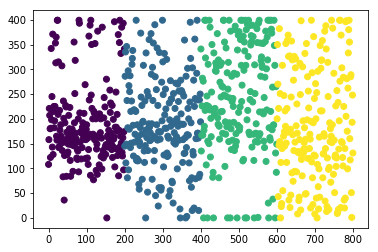

mean
191.875
192.297201018
239.938325991
191.274576271
median
175.0
182.0
234.0
176.0
standard deviation
81.2465381974
91.5967499301
108.11527411
117.960547259


In [45]:
plt.scatter(x=range(len(ind_plot)), y=ac[ind_plot, 0], c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(ac[np.where(y_train==i), 0]))
print('median')
for i in range(4):
    print(np.median(ac[np.where(y_train==i), 0]))
print('standard deviation')
for i in range(4):
    print(np.std(ac[np.where(y_train==i), 0]))

best autocorrelation value

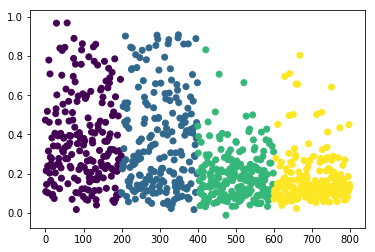

mean
0.372073328956
0.379214546077
0.193823696543
0.186477033994
median
0.341377909072
0.333020290723
0.164086248619
0.142262373738
standard deviation
0.21256287867
0.237877954219
0.126313498888
0.134447013177


In [46]:
plt.scatter(x=range(len(ind_plot)), y=ac[ind_plot, 1], c=y_train[ind_plot])
plt.show()
print('mean')
for i in range(4):
    print(np.mean(ac[np.where(y_train==i), 1]))
print('median')
for i in range(4):
    print(np.median(ac[np.where(y_train==i), 1]))
print('standard deviation')
for i in range(4):
    print(np.std(ac[np.where(y_train==i), 1]))

In the next cell I will try to look at a possible way to look locally at the autocorrelation function. To see if there is some variation in the length of a heartbeat. But first I need to reconstruct a lof of signals.

In [143]:
X_cut = X_train[ind_plot, 1000:9000]
wind_ac = 600
shift = 300
n_shift = int((X_cut.shape[1]-wind_c)/shift)+1
lag_local = np.zeros(shape=[X_cut.shape[0], n_shift])
ac_local = np.zeros(shape=[X_cut.shape[0], n_shift])
for i in range(n_shift):
    r = np.apply_along_axis(best_lag, 1, X_cut[:, i*shift:(i*shift+wind_ac)])
    lag_local[:,i] = r[:, 0]
    ac_local[:,i] = r[:, 1]


/home/aritz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [156]:
print(ac_local[-2,:])
r1 = np.zeros(shape=[1, 50])
for i in range(25):
    r1[0, 2*i:2*(i+1)] = best_lag(X_cut[-2, i*shift:(i*shift+wind_ac)])
print(r1)

[ 0.86  1.    0.6   0.59  0.87  0.91  0.47  0.61  0.15  0.41  0.49  0.58
  0.39  1.06  0.55  1.01  0.08   nan   nan   nan   nan   nan   nan   nan
   nan]
[[  2.44e+02   8.63e-01   2.80e+02   1.00e+00   1.50e+02   5.99e-01
    2.08e+02   5.90e-01   2.23e+02   8.72e-01   2.49e+02   9.11e-01
    1.27e+02   4.65e-01   2.91e+02   6.10e-01   2.93e+02   1.52e-01
    1.20e+02   4.05e-01   1.20e+02   4.88e-01   3.92e+02   5.81e-01
    3.13e+02   3.92e-01   2.70e+02   1.06e+00   1.30e+02   5.55e-01
    2.69e+02   1.01e+00   0.00e+00   8.21e-02   0.00e+00        nan
    0.00e+00        nan   0.00e+00        nan   0.00e+00        nan
    0.00e+00        nan   0.00e+00        nan   0.00e+00        nan
    0.00e+00        nan]]


/home/aritz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


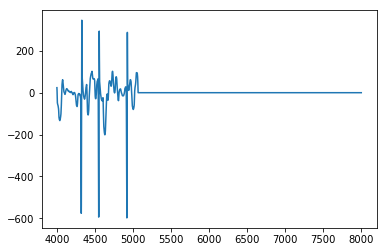

In [159]:
plt.plot(np.arange(4000, 8000), X_cut[-2, 4000:8000])
plt.show()

Next I look if the signal is equal to 0 from around 5500 on.

(6822,)


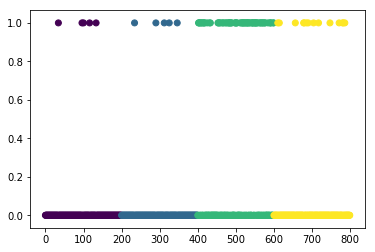

# times the tail is equal to 0 from 5500 =  433
mean
0.0509900990099
0.0396946564885
0.374449339207
0.108474576271
median
0.0
0.0
0.0
0.0
standard deviation
0.219977518881
0.19524085314
0.483980404122
0.310978845863


In [162]:
X_null_tail2 = np.array([np.all(X_train[i, 5500:5510]==0) for i in range(X_train.shape[0])])
print(X_null_tail3.shape)
plt.scatter(x=range(X_null_tail2[ind_plot].shape[0]), y=X_null_tail2[ind_plot], c=y_train[ind_plot])
plt.show()
print('# times the tail is equal to 0 from 5500 = ', np.sum(X_null_tail2))
print('mean')
for i in range(4):
    print(np.mean(X_null_tail2[np.where(y_train==i)]))
print('median')
for i in range(4):
    print(np.median(X_null_tail2[np.where(y_train==i)]))
print('standard deviation')
for i in range(4):
    print(np.std(X_null_tail2[np.where(y_train==i)]))

(6822,)


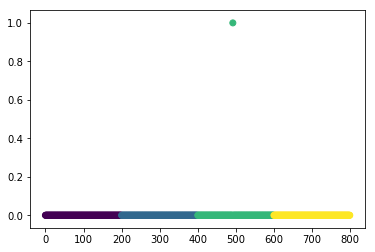

# times the tail is equal to 0 from 5000 =  1
mean
0.0
0.0
0.00440528634361
0.0
median
0.0
0.0
0.0
0.0
standard deviation
0.0
0.0
0.0662259752351
0.0


In [173]:
X_null_tail3 = np.array([np.all(X_train[i, 2500:2510]==0) for i in range(X_train.shape[0])])
print(X_null_tail3.shape)
plt.scatter(x=range(X_null_tail3[ind_plot].shape[0]), y=X_null_tail3[ind_plot], c=y_train[ind_plot])
plt.show()
print('# times the tail is equal to 0 from 5000 = ', np.sum(X_null_tail3))
print('mean')
for i in range(4):
    print(np.mean(X_null_tail3[np.where(y_train==i)]))
print('median')
for i in range(4):
    print(np.median(X_null_tail3[np.where(y_train==i)]))
print('standard deviation')
for i in range(4):
    print(np.std(X_null_tail3[np.where(y_train==i)]))

In [184]:
ind_problem = tuple(np.where(X_null_tail3==1))
print(tuple(np.where(X_null_tail3==1)))

(array([2468]),)


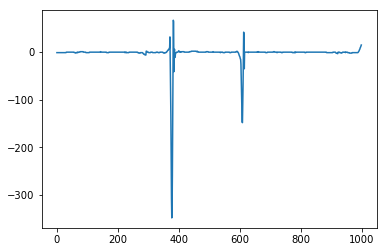

In [187]:

axes = plt.gca()
axes.set_ylim([ymin,ymax])
plt.plot(X_train[2468, 1000:2000])
plt.show()

In the next cell we look at how to merge some vectors into one data frame.

In [52]:
X_mer1 = np.vstack([X_var, X_null_tail])
print(np.shape(X_mer1))
print(np.shape(np.transpose(X_mer1)))
X_mer1T = np.transpose(X_mer1)
print(ac.shape)
X_mer2 = np.hstack([X_mer1T, ac])
print(X_mer2.shape)

(2, 6822)
(6822, 2)
(6822, 2)
(6822, 4)


## Transformer to create meta predictors

This transformer builds meta-predictors but for the reconstructed signal.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.utils.random import sample_without_replacement
import numpy as np
from sklearn.preprocessing import StandardScaler

class Meta_pred_reconstructed(BaseEstimator, TransformerMixin):
    """Builds some meta predictors out of a reconstructed signal"""
    def __init__(self, burn_in=0, end_pt=None, wind=500, frac_max=0.6, frac_sma=0.2):
        self.burn_in = burn_in
        self.end_pt = end_pt
        self.wind = wind
        self.frac_max = frac_max
        self.frac_sma = frac_sma
    
    
    def fit(self, X, y=None):
        None
        return self

    def transform(self, X, y=None):
        
        # The next function rebuilds the signal by duplicating the non zero part
        def complete_signal(A):
            X = np.empty_like (A)
            X[:] = A
            is_zero = np.zeros(shape=[X.shape[0]])
            length_full = X.shape[1]
            half_lenfth = int(length_full/2)
            n_K = int(length_full/1000)
            for i in range(1, n_K):
                for j in range(5):
                    a = i*1000 + j*200 
                    b = i*1000 + (j+1)*200
                    bool_half = (b >= half_lenfth)
                    if bool_half == False:
                        n_repeat = int(length_full/a)-1
                    X_null_tail = np.array([((np.all(X[k, a:b]==0)) & (is_zero[k]==0)) for k in range(X.shape[0])])
                    if np.sum(X_null_tail) > 0:
                        ind_new = np.hstack(np.where(X_null_tail==1))
                        is_zero[ind_new] = 1
                        if bool_half == True:
                            X[ind_new, a:length_full]=X[ind_new, :length_full-a]
                        else:
                            for k in range(n_repeat):
                                X[ind_new, a+k*a:a+(k+1)*a]=X[ind_new, :a]
            return(X)
        # end of the function
        
        # First I detect which signals have a null taill
        X_null_tail = np.array([np.all(X[i, 10000:10050]==0) for i in range(X.shape[0])])
        X_null_tail2 = np.array([np.all(X[i, 5500:5550]==0) for i in range(X.shape[0])])
        
        # Then I reconstruct the signal
        X_rec = complete_signal(X)
        
        # I look at some global properties of the signal
        X_std = np.std(X_rec, axis=1)
        X_sum = np.sum(X_rec, axis=1)
        X_abs_sum = np.absolute(X_sum)
        X_abs = np.absolute(X_rec)
        X_max_abs = np.max(X_abs, axis=1)
        X_n_per = np.array([sum(((X_rec[i] <= 600) & (500 <= X_rec[i]))) for i in range(X_rec.shape[0])])
        X_max_or_min = np.array([(max(X_rec[i][1000:])>=-min(X_rec[i][1000:])) for i in range(X_rec.shape[0])])
        X_max = np.max(X_rec, axis=1)
        X_min = np.min(X_rec, axis=1)
        

        # Here I remove the burn-in period and the tail        
        if (self.end_pt is None) == True:
            X_cut = X_rec[:, self.burn_in:]
        else:
            X_cut = X_rec[:, self.burn_in: self.end_pt]
            
        # Then I look at some local preperties
        n_wind = int(X_cut.shape[1]/self.wind)
        X_max_abs_s = np.zeros(shape=(X_cut.shape[0], n_wind))
        X_n_peaks = np.zeros(shape=(X_cut.shape[0], n_wind))
        X_n_small = np.zeros(shape=(X.shape[0], n_wind))
        for i in range(n_wind):
            X_max_abs_s[:, i] = np.max(
                np.abs(X_cut[:, i*self.wind:(i+1)*self.wind]), axis=1)
            X_n_peaks[:, i] = np.sum(
                (np.abs(X_cut[:, i*self.wind:(i+1)*self.wind])
                 > self.frac_max*X_max_abs_s[:, i].reshape(X_cut.shape[0],1)), axis=1)
            X_n_small[:, i] = np.sum(
                (np.abs(X_cut[:, i*self.wind:(i+1)*self.wind])
                 < self.frac_sma*X_max_abs_s[:, i].reshape(X_cut.shape[0],1)), axis=1)
        X_max_std = np.std(X_max_abs_s, axis=1)
        X_n_peaks_mean = np.mean(X_n_peaks, axis=1)
        X_n_peaks_std = np.std(X_n_peaks, axis=1)
        X_n_small_mean = np.mean(X_n_small, axis=1)
        X_n_small_std = np.std(X_n_small, axis=1)
        
        # This function resturns for one signal the best lag within a range of lag
        # (for the autocorrelation) and the associated autocorrelation.
        def best_lag(x, lag1=100, lag2=500):
            n = len(x)
            variance = x.var()
            x = x-x.mean()
            r = np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(lag1, lag2)])
            ac = r/(variance*(np.arange(n-lag1, n-lag2, -1)))
            result = np.array([np.argmax(ac), np.max(ac)])
            return result
        
        X_ac_full = np.apply_along_axis(best_lag, 1, X_cut)
        
        # Then I look locally at the lag. Here it is necessary to have 
        # the signal reconstructed.
        wind_ac = 1000
        shift = 500
        n_shift = int((X_cut.shape[1]-wind_ac)/shift)+1
        lag_local = np.zeros(shape=[X_cut.shape[0], n_shift])
        ac_local = np.zeros(shape=[X_cut.shape[0], n_shift])
        for i in range(n_shift):
            r = np.apply_along_axis(best_lag, 1, X_cut[:, i*shift:(i*shift+wind_ac)])
            lag_local[:,i] = r[:, 0]
            ac_local[:,i] = r[:, 1]
    
        #lag_l_m = np.mean(lag_local, axis=1)
        #lag_l_std = np.std(lag_local, axis=1)
        ac_l_m = np.mean(ac_local, axis=1)
        ac_l_std = np.std(ac_local, axis=1)
        
        X_v = np.transpose(np.vstack([X_std,
                                        X_abs_sum,
                                        X_max_abs,
                                        X_n_per,
                                        X_max_or_min,
                                        X_max,
                                        X_min,
                                        X_max_std,
                                        X_n_peaks_mean,
                                        X_n_peaks_std,
                                        X_n_small_mean,
                                        X_n_small_std,
                                        ac_l_m,
                                        ac_l_std
                                     ]))
        #                                X_f_max_mmin_mean,
        #                                X_f_max_mmin_std]))
        
        X_new1 = np.hstack([X_v, X_ac_full])

        X_bin = np.transpose(np.vstack([X_null_tail, X_null_tail2]))
        
        X_new = np.hstack([X_new1, X_bin])
        return(X_new)

## Filtering, Creation of meta predictors, and standardization

In [7]:
ind_coef_kept = np.arange(1000)
wind = 500
meta = Meta_pred_reconstructed(burn_in = 1000, end_pt=9000, wind=wind)
standardscaler = StandardScaler()
pp_pipe = Pipeline(steps=[
                          ('meta', meta),
                          ('std', standardscaler)])

In [8]:
X_meta_std = pp_pipe.fit_transform(X_train)

In [9]:
print(X_meta_std.shape)

(6822, 18)


## Tree

Let's try to use a tree with this new data set.

In [22]:
tree = DecisionTreeClassifier(random_state=66)
parameters_tree = {'criterion':['gini'],
                   'max_depth':[5, 6, 10],
#                   'min_impurity_split':[0.01, 0.001, 0],
                   'min_impurity_decrease':[0, 0.001],
                   'class_weight':[None],
                   'min_samples_split':[2, 3],
                   'max_features':[None]}
#parameters_tree = {'criterion':['gini', 'entropy'],
#                   'max_depth':[3, 5, 8, 10, 15, 30],
#                   'min_impurity_decrease':[0.1, 0.01, 0.001, 0],
#                   'class_weight':['balanced', None]}

In [267]:
gscv_tree = GridSearchCV(tree, parameters_tree, cv=5)
gscv_tree.fit(X_meta_std, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=66,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini'], 'max_depth': [5, 6, 7, 10, 12], 'min_impurity_decrease': [0, 0.001, 0.01], 'class_weight': [None], 'min_samples_split': [2, 3], 'max_features': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [268]:
print(gscv_tree.best_score_)
print(gscv_tree.best_params_)

0.652008208736
{'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_impurity_decrease': 0.001, 'min_samples_split': 2}


In [269]:
gscv_tree_results = gscv_tree.cv_results_
ranking_results_tree = np.argsort(gscv_tree_results['mean_test_score'])
n_best = 10
best_params_tree = [gscv_tree_results['params'][i] for i in ranking_results_tree[-n_best:]]
best_scores_tree = [gscv_tree_results['mean_test_score'][i] for i in ranking_results_tree[-n_best:]]
print('Best parameters:')
print(best_params_tree)
print('And their scores')
print(best_scores_tree)

Best parameters:
[{'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_impurity_decrease': 0, 'min_samples_split': 3}, {'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_impurity_decrease': 0, 'min_samples_split': 2}, {'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_impurity_decrease': 0.001, 'min_samples_split': 2}, {'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_impurity_decrease': 0.001, 'min_samples_split': 3}, {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_impurity_decrease': 0, 'min_samples_split': 3}, {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_impurity_decrease': 0, 'min_samples_split': 2}, {'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_impurity_decrease': 0.001, 'min_samples_split': 3}, {'class_weight': None, 'c

In [23]:
tree.set_params(class_weight=None, criterion='gini', max_depth=5, max_features=None,
                min_impurity_decrease=0.001, min_samples_split=2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=66,
            splitter='best')

In [25]:
pipe_full = Pipeline(steps = [('meta', meta),
                              ('std', standardscaler),
                              ('tree', tree)])

Confustion matrix for tree

Accuracy score =  0.652747252747
Confusion matrix, without normalization
[[712  94   6   5]
 [239 128   2  15]
 [ 36   1   9   3]
 [ 47  26   0  42]]
Normalized confusion matrix
[[ 0.87  0.12  0.01  0.01]
 [ 0.62  0.33  0.01  0.04]
 [ 0.73  0.02  0.18  0.06]
 [ 0.41  0.23  0.    0.37]]


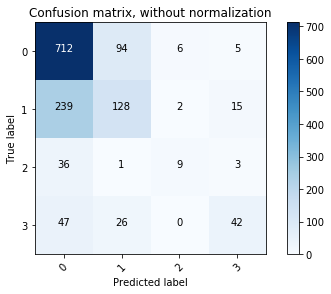

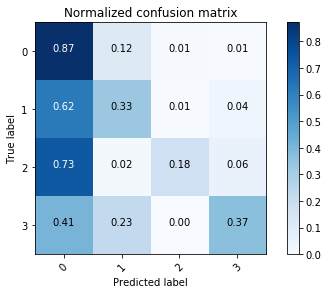

Accuracy score =  0.649816849817
Confusion matrix, without normalization
[[767  26   7   1]
 [286  76   8   7]
 [ 44   0  12   0]
 [ 71  22   6  32]]
Normalized confusion matrix
[[ 0.96  0.03  0.01  0.  ]
 [ 0.76  0.2   0.02  0.02]
 [ 0.79  0.    0.21  0.  ]
 [ 0.54  0.17  0.05  0.24]]


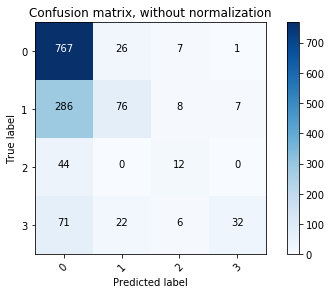

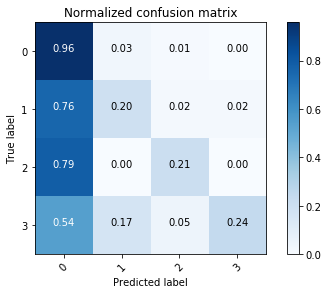

Accuracy score =  0.640762463343
Confusion matrix, without normalization
[[738  52  10   7]
 [282  81   7  16]
 [ 19   9  21   1]
 [ 42  41   4  34]]
Normalized confusion matrix
[[ 0.91  0.06  0.01  0.01]
 [ 0.73  0.21  0.02  0.04]
 [ 0.38  0.18  0.42  0.02]
 [ 0.35  0.34  0.03  0.28]]


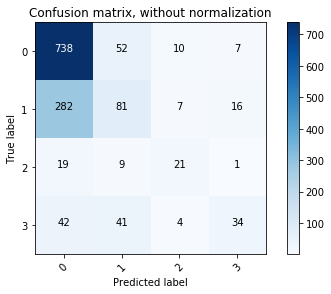

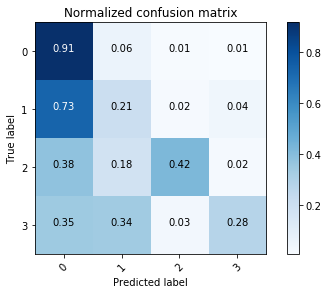

Accuracy score =  0.650293255132
Confusion matrix, without normalization
[[745  20  16  20]
 [305  71   3  25]
 [ 27   1  13   4]
 [ 40  14   2  58]]
Normalized confusion matrix
[[ 0.93  0.02  0.02  0.02]
 [ 0.75  0.18  0.01  0.06]
 [ 0.6   0.02  0.29  0.09]
 [ 0.35  0.12  0.02  0.51]]


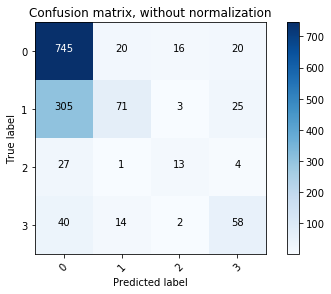

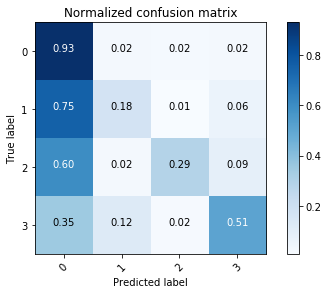

Accuracy score =  0.653958944282
Confusion matrix, without normalization
[[740  63   8   3]
 [289 101   2  22]
 [ 16   2   6   3]
 [ 46  18   0  45]]
Normalized confusion matrix
[[ 0.91  0.08  0.01  0.  ]
 [ 0.7   0.24  0.    0.05]
 [ 0.59  0.07  0.22  0.11]
 [ 0.42  0.17  0.    0.41]]


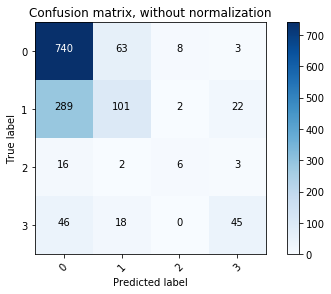

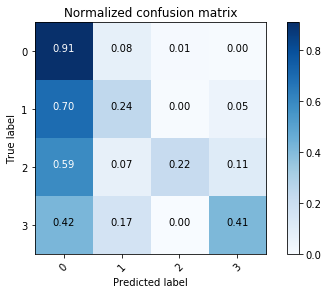

In [28]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=5, random_state=12)

for train_indices, test_indices in k_fold.split(X_train):  
    pipe_full.fit(X_train[train_indices], y_train[train_indices])
    y_pred = pipe_full.predict(X_train[test_indices])
    
    # Print accuracy score
    acc_score = accuracy_score(y_true=y_train[test_indices],
                               y_pred=y_pred)
    print('Accuracy score = ', acc_score)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_train[test_indices], y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3],
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3], normalize=True,
                      title='Normalized confusion matrix')

    plt.show()    

## Predicting the categories for the test set.

In [ ]:
pipe_tree = Pipeline(steps=[('meta', meta_builder), ('standardscaler', standardscaler), ('tree', tree)])
y_test = pipe_tree.predict(X_test)


In [160]:
print(y_test[:30])
print(y_test[:30].astype('int'))

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]


## Tree with SMOTE

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
import numpy as np

class SMOTEdTree(BaseEstimator, TransformerMixin):
    """Take an estimator and apply SMOTE on the training data before fitting it"""
    def __init__(self, criterion='gini', max_depth=None, max_features=None,
                 min_impurity_decrease=0., min_samples_split=2, random_state_tree=None,
                 ratio='auto', random_state_SMOTE=None, k_neighbors=5,
                 m_neighbors=10, out_step=0.5, kind='regular', svm_estimator=None,
                 n_jobs=1):
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_impurity_decrease = min_impurity_decrease
        self.min_samples_split = min_samples_split
        self.random_state_tree = random_state_tree
        self.ratio = ratio
        self.random_state_SMOTE = random_state_SMOTE
        self.k_neighbors = k_neighbors
        self.m_neighbors = m_neighbors
        self.out_step = out_step
        self.kind = kind
        self.svm_estimator = svm_estimator
        self.n_jobs = n_jobs
        self.tree = DecisionTreeClassifier()
        
    def fit(self, X, y):
        smote = SMOTE(ratio=self.ratio, random_state=self.random_state_SMOTE,
                      k_neighbors=self.k_neighbors,
                      m_neighbors=self.m_neighbors,
                      out_step=self.out_step,
                      kind=self.kind,
                      svm_estimator=self.svm_estimator,
                      n_jobs=self.n_jobs)
        self.tree.set_params(class_weight=None, criterion=self.criterion,
                             max_depth=self.max_depth,
                             max_features=self.max_features,
                             min_impurity_decrease=self.min_impurity_decrease,
                             min_samples_split=self.min_samples_split,
                             random_state=self.random_state_tree)
        X_new, y_new = smote.fit_sample(X, y)
        self.tree.fit(X_new, y_new)
        return self
    
    def predict(self, X):
        return sefl.tree.predict(X)
    
    def score(self, X, y):
        return self.tree.score(X, y)

Let's try to do some grid search to determine if using SMOTE can have a positive effect.

In [11]:
smote_tree = SMOTEdTree(random_state_tree=66)

In [14]:
#parameters_smote_tree = {'criterion':['gini'],
#                   'max_depth':[5, 10, 15],
#                   'min_impurity_decrease':[0, 0.01],
#                   'min_samples_split':[2, 3],
#                   'max_features':[None],
#                   'k_neighbors':[2, 5],
#                   'kind':['regular', 'borderline1', 'borderline2', 'svm'],
#                   'ratio':['auto', 'minority', 'not minority', 'all']}
parameters_smote_tree = {'criterion':['gini'],
                   'max_depth':[5, 10, 15],
                   'min_impurity_decrease':[0, 0.01],
                   'min_samples_split':[2, 3],
                   'max_features':[None],
                   'k_neighbors':[2, 5],
                   'kind':['regular'],
                   'ratio':['auto']}

In [18]:
ind_toy = np.concatenate([ind_by_cat[0][:50],
                           ind_by_cat[1][:30],
                           ind_by_cat[2][:15],
                           ind_by_cat[3][:15]])
X_toy = X_meta_std[ind_toy]
y_toy = y_train[ind_toy]

In [15]:
gscv_smote_tree = GridSearchCV(estimator=smote_tree,
                               param_grid=parameters_smote_tree,
                               cv=5)
gscv_smote_tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SMOTEdTree(criterion='gini', k_neighbors=5, kind='regular', m_neighbors=10,
      max_depth=None, max_features=None, min_impurity_decrease=0.0,
      min_samples_split=2, n_jobs=1, out_step=0.5, random_state_SMOTE=None,
      random_state_tree=66, ratio='auto', svm_estimator=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'k_neighbors': [2, 5], 'max_features': [None], 'min_samples_split': [2, 3], 'ratio': ['auto'], 'criterion': ['gini'], 'kind': ['regular'], 'min_impurity_decrease': [0, 0.01], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
print(gscv_smote_tree.best_score_)
print(gscv_smote_tree.best_params_)

0.397537379068
{'k_neighbors': 2, 'max_features': None, 'min_samples_split': 2, 'ratio': 'auto', 'criterion': 'gini', 'kind': 'regular', 'min_impurity_decrease': 0, 'max_depth': 10}


In [17]:
gscv_smote_tree_results = gscv_smote_tree.cv_results_
ranking_results_smote_tree = np.argsort(gscv_smote_tree_results['mean_test_score'])
n_best = 10
best_params_smote_tree = [gscv_smote_tree_results['params'][i] for i in ranking_results_smote_tree[-n_best:]]
best_scores_smote_tree = [gscv_smote_tree_results['mean_test_score'][i]
                          for i in ranking_results_smote_tree[-n_best:]]
print('Best parameters:')
print(best_params_smote_tree)
print('And their scores')
print(best_scores_smote_tree)

Best parameters:
[{'k_neighbors': 2, 'max_features': None, 'min_samples_split': 2, 'ratio': 'auto', 'criterion': 'gini', 'kind': 'regular', 'min_impurity_decrease': 0, 'max_depth': 5}, {'k_neighbors': 2, 'max_features': None, 'min_samples_split': 3, 'ratio': 'auto', 'criterion': 'gini', 'kind': 'regular', 'min_impurity_decrease': 0, 'max_depth': 5}, {'k_neighbors': 5, 'max_features': None, 'min_samples_split': 3, 'ratio': 'auto', 'criterion': 'gini', 'kind': 'regular', 'min_impurity_decrease': 0, 'max_depth': 10}, {'k_neighbors': 2, 'max_features': None, 'min_samples_split': 3, 'ratio': 'auto', 'criterion': 'gini', 'kind': 'regular', 'min_impurity_decrease': 0, 'max_depth': 10}, {'k_neighbors': 5, 'max_features': None, 'min_samples_split': 2, 'ratio': 'auto', 'criterion': 'gini', 'kind': 'regular', 'min_impurity_decrease': 0, 'max_depth': 10}, {'k_neighbors': 5, 'max_features': None, 'min_samples_split': 2, 'ratio': 'auto', 'criterion': 'gini', 'kind': 'regular', 'min_impurity_decrease

## k-nearest neighbors

In [64]:
knn = KNeighborsClassifier()
parameters_knn = {'n_neighbors':[1, 2, 3, 5, 10, 12, 15, 20, 25, 30, 50]}

In [113]:
gscv_knn = GridSearchCV(knn, parameters_knn, cv=3)
gscv_knn.fit(X_meta_std, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 5, 10, 12, 15, 20, 25, 30, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [114]:
print(gscv_knn.best_score_)
print(gscv_knn.best_params_)

0.609791849897
{'n_neighbors': 30}


In [115]:
gscv_knn_results = gscv_knn.cv_results_
ranking_results_knn = np.argsort(gscv_knn_results['mean_test_score'])
n_best = 10
best_params_knn = [gscv_knn_results['params'][i] for i in ranking_results_knn[-n_best:]]
best_scores_knn = [gscv_knn_results['mean_test_score'][i] for i in ranking_results_knn[-n_best:]]
print('Best parameters:')
print(best_params_knn)
print('And their scores')
print(best_scores_knn)

Best parameters:
[{'n_neighbors': 3}, {'n_neighbors': 5}, {'n_neighbors': 2}, {'n_neighbors': 10}, {'n_neighbors': 12}, {'n_neighbors': 15}, {'n_neighbors': 20}, {'n_neighbors': 25}, {'n_neighbors': 50}, {'n_neighbors': 30}]
And their scores
[0.56757549105834071, 0.57783641160949872, 0.58106127235414839, 0.59718557607739664, 0.5980650835532102, 0.60451480504250954, 0.60700674289064793, 0.60832600410436821, 0.60920551158018177, 0.60979184989739077]


In [116]:
knn.set_params(n_neighbors=30)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')

Confusion matrix for k-nearest-neighbors

Accuracy score =  0.622710622711
Confusion matrix, without normalization
[[786  27   1   3]
 [326  57   0   1]
 [ 42   4   3   0]
 [ 94  17   0   4]]
Normalized confusion matrix
[[ 0.96  0.03  0.    0.  ]
 [ 0.85  0.15  0.    0.  ]
 [ 0.86  0.08  0.06  0.  ]
 [ 0.82  0.15  0.    0.03]]


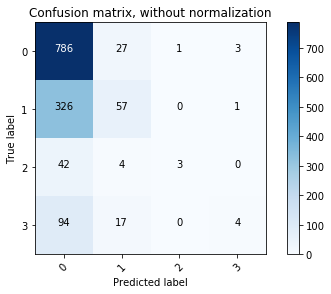

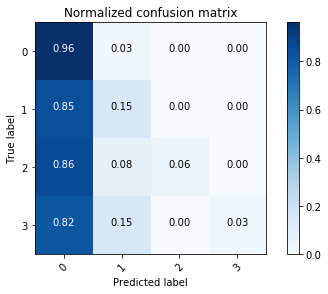

Accuracy score =  0.604395604396
Confusion matrix, without normalization
[[766  32   1   2]
 [319  54   1   3]
 [ 51   1   4   0]
 [111  19   0   1]]
Normalized confusion matrix
[[ 0.96  0.04  0.    0.  ]
 [ 0.85  0.14  0.    0.01]
 [ 0.91  0.02  0.07  0.  ]
 [ 0.85  0.15  0.    0.01]]


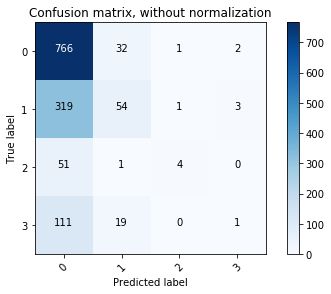

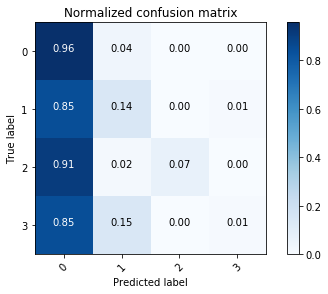

Accuracy score =  0.611436950147
Confusion matrix, without normalization
[[766  40   1   0]
 [317  62   1   6]
 [ 48   1   1   0]
 [ 98  18   0   5]]
Normalized confusion matrix
[[ 0.95  0.05  0.    0.  ]
 [ 0.82  0.16  0.    0.02]
 [ 0.96  0.02  0.02  0.  ]
 [ 0.81  0.15  0.    0.04]]


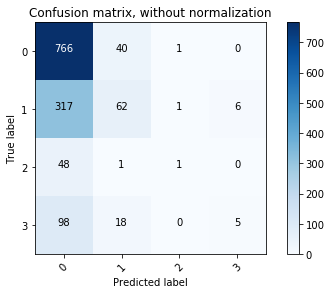

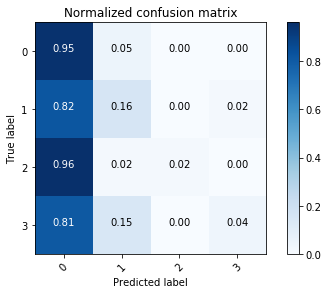

Accuracy score =  0.614369501466
Confusion matrix, without normalization
[[768  30   0   3]
 [337  67   0   0]
 [ 43   1   1   0]
 [ 91  20   1   2]]
Normalized confusion matrix
[[ 0.96  0.04  0.    0.  ]
 [ 0.83  0.17  0.    0.  ]
 [ 0.96  0.02  0.02  0.  ]
 [ 0.8   0.18  0.01  0.02]]


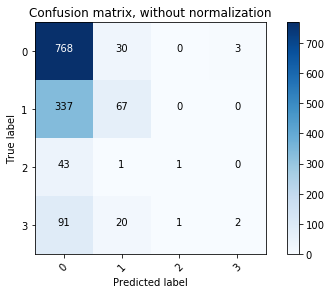

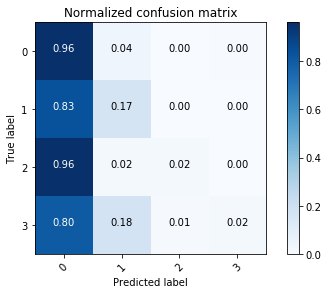

Accuracy score =  0.607771260997
Confusion matrix, without normalization
[[766  46   0   2]
 [354  56   1   3]
 [ 21   3   3   0]
 [ 89  16   0   4]]
Normalized confusion matrix
[[ 0.94  0.06  0.    0.  ]
 [ 0.86  0.14  0.    0.01]
 [ 0.78  0.11  0.11  0.  ]
 [ 0.82  0.15  0.    0.04]]


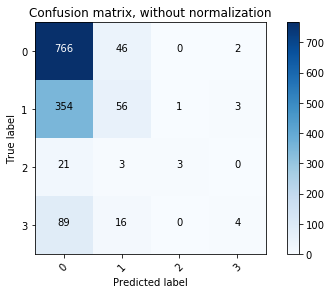

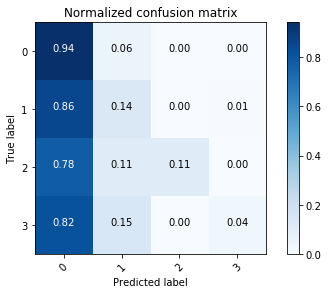

In [118]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=5)
for train_indices, test_indices in k_fold.split(X_meta_std):
    
    knn.fit(X_meta_std[train_indices], y_train[train_indices])
    y_pred = knn.predict(X_meta_std[test_indices])
    
    # Print accuracy score
    acc_score = accuracy_score(y_true=y_train[test_indices],
                               y_pred=y_pred)
    print('Accuracy score = ', acc_score)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_train[test_indices], y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3],
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3], normalize=True,
                      title='Normalized confusion matrix')

    plt.show()    

## AdaBoost

In [129]:
ada = AdaBoostClassifier(random_state=10)
parameters_ada = {'n_estimators':[13, 14, 15, 16, 17],
                  'learning_rate':[0.7, 0.6, 0.5, 0.4],
                  'algorithm':['SAMME', 'SAMME.R']}

In [130]:
gscv_ada = GridSearchCV(ada, parameters_ada, cv=3)
gscv_ada.fit(X_meta_std, y_train)
print(gscv_ada.best_score_)
print(gscv_ada.best_params_)

0.603195543829
{'algorithm': 'SAMME.R', 'learning_rate': 0.6, 'n_estimators': 14}


In [131]:
ada.set_params(n_estimators=14, learning_rate=0.6, algorithm='SAMME.R')

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.6, n_estimators=14, random_state=10)

In [132]:
gscv_ada_results = gscv_ada.cv_results_
ranking_results_ada = np.argsort(gscv_ada_results['mean_test_score'])
n_best = 10
best_params_ada = [gscv_ada_results['params'][i] for i in ranking_results_ada[-n_best:]]
best_scores_ada = [gscv_ada_results['mean_test_score'][i] for i in ranking_results_ada[-n_best:]]
print('Best parameters:')
print(best_params_ada)
print('And their scores')
print(best_scores_ada)

Best parameters:
[{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 14}, {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 16}, {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 17}, {'algorithm': 'SAMME.R', 'learning_rate': 0.4, 'n_estimators': 15}, {'algorithm': 'SAMME.R', 'learning_rate': 0.4, 'n_estimators': 16}, {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 13}, {'algorithm': 'SAMME.R', 'learning_rate': 0.4, 'n_estimators': 17}, {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 15}, {'algorithm': 'SAMME.R', 'learning_rate': 0.6, 'n_estimators': 13}, {'algorithm': 'SAMME.R', 'learning_rate': 0.6, 'n_estimators': 14}]
And their scores
[0.59850483729111692, 0.5986514218704192, 0.59982409850483731, 0.60055702140134859, 0.60055702140134859, 0.60055702140134859, 0.60070360598065087, 0.60099677513925531, 0.60260920551158015, 0.60319554382878926]


Confusion matrix for AdaBoostClassifier.

Accuracy score =  0.603663003663
Confusion matrix, without normalization
[[784  26   7   0]
 [345  36   3   0]
 [ 42   3   4   0]
 [ 96  18   1   0]]
Normalized confusion matrix
[[ 0.96  0.03  0.01  0.  ]
 [ 0.9   0.09  0.01  0.  ]
 [ 0.86  0.06  0.08  0.  ]
 [ 0.83  0.16  0.01  0.  ]]


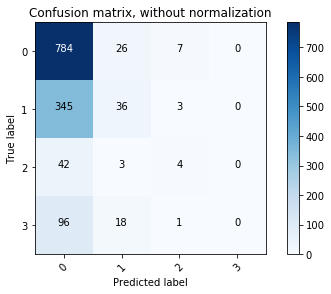

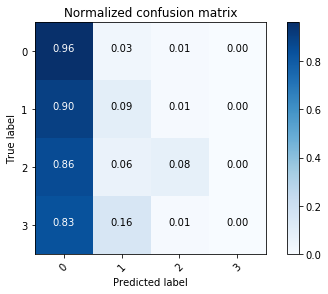

Accuracy score =  0.59706959707
Confusion matrix, without normalization
[[778  13  10   0]
 [345  25   7   0]
 [ 44   0  12   0]
 [120  11   0   0]]
Normalized confusion matrix
[[ 0.97  0.02  0.01  0.  ]
 [ 0.92  0.07  0.02  0.  ]
 [ 0.79  0.    0.21  0.  ]
 [ 0.92  0.08  0.    0.  ]]


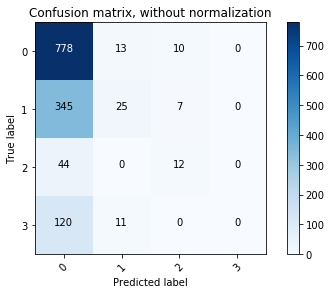

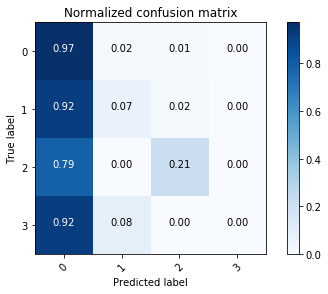

Accuracy score =  0.604105571848
Confusion matrix, without normalization
[[772  30   5   0]
 [335  46   5   0]
 [ 43   1   6   0]
 [102  18   1   0]]
Normalized confusion matrix
[[ 0.96  0.04  0.01  0.  ]
 [ 0.87  0.12  0.01  0.  ]
 [ 0.86  0.02  0.12  0.  ]
 [ 0.84  0.15  0.01  0.  ]]


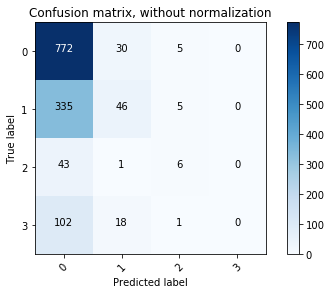

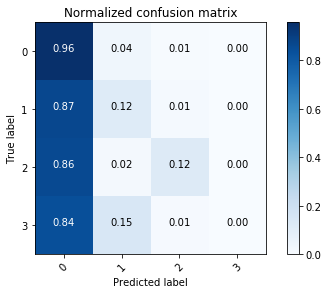

Accuracy score =  0.593841642229
Confusion matrix, without normalization
[[761  36   4   0]
 [358  46   0   0]
 [ 42   0   3   0]
 [107   7   0   0]]
Normalized confusion matrix
[[ 0.95  0.04  0.    0.  ]
 [ 0.89  0.11  0.    0.  ]
 [ 0.93  0.    0.07  0.  ]
 [ 0.94  0.06  0.    0.  ]]


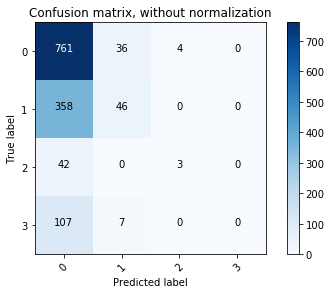

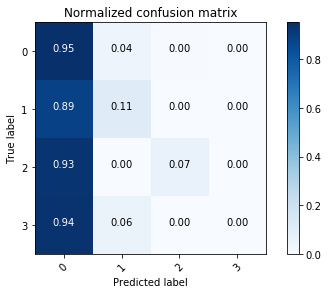

Accuracy score =  0.599706744868
Confusion matrix, without normalization
[[805   2   7   0]
 [399  10   5   0]
 [ 24   0   3   0]
 [108   1   0   0]]
Normalized confusion matrix
[[ 0.99  0.    0.01  0.  ]
 [ 0.96  0.02  0.01  0.  ]
 [ 0.89  0.    0.11  0.  ]
 [ 0.99  0.01  0.    0.  ]]


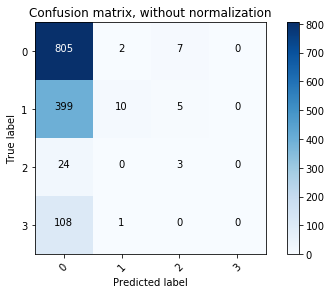

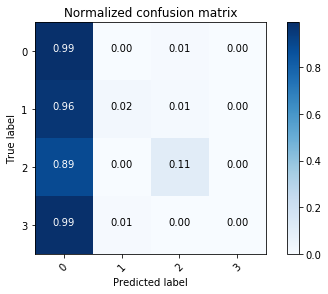

In [134]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=5)
for train_indices, test_indices in k_fold.split(X_meta_std):
    
    ada.fit(X_meta_std[train_indices], y_train[train_indices])
    y_pred = ada.predict(X_meta_std[test_indices])
    
    # Print accuracy score
    acc_score = accuracy_score(y_true=y_train[test_indices],
                               y_pred=y_pred)
    print('Accuracy score = ', acc_score)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_train[test_indices], y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3],
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3], normalize=True,
                      title='Normalized confusion matrix')

    plt.show()    

## Support vector machine.

In [148]:
svc = SVC(random_state=10)
parameters_svc = {'C':[3, 2.5, 2, 1.5, 1, 0.5],
                 'kernel':['poly', 'rbf'],
                 'class_weight':['balanced', None]}

In [149]:
type(weights_svc)

dict

In [150]:
gscv_svc = GridSearchCV(svc, parameters_svc, cv=3)
gscv_svc.fit(X_meta_std, y_train)
print(gscv_svc.best_score_)
print(gscv_svc.best_params_)

0.610085019056
{'C': 3, 'class_weight': None, 'kernel': 'rbf'}


In [151]:
gscv_svc_results = gscv_svc.cv_results_
ranking_results_svc = np.argsort(gscv_svc_results['mean_test_score'])
n_best = 10
best_params_svc = [gscv_svc_results['params'][i] for i in ranking_results_svc[-n_best:]]
best_scores_svc = [gscv_svc_results['mean_test_score'][i] for i in ranking_results_svc[-n_best:]]
print('Best parameters:')
print(best_params_svc)
print('And their scores')
print(best_scores_svc)

Best parameters:
[{'C': 0.5, 'class_weight': None, 'kernel': 'poly'}, {'C': 3, 'class_weight': None, 'kernel': 'poly'}, {'C': 1.5, 'class_weight': None, 'kernel': 'poly'}, {'C': 1, 'class_weight': None, 'kernel': 'poly'}, {'C': 0.5, 'class_weight': None, 'kernel': 'rbf'}, {'C': 1, 'class_weight': None, 'kernel': 'rbf'}, {'C': 1.5, 'class_weight': None, 'kernel': 'rbf'}, {'C': 2.5, 'class_weight': None, 'kernel': 'rbf'}, {'C': 3, 'class_weight': None, 'kernel': 'rbf'}, {'C': 2, 'class_weight': None, 'kernel': 'rbf'}]
And their scores
[0.6053943125183231, 0.6059806508355321, 0.6065669891527411, 0.60671357373204338, 0.60744649662855466, 0.60832600410436821, 0.60949868073878632, 0.60993843447669305, 0.61008501905599533, 0.61008501905599533]


In [152]:
svc.set_params(C=3, class_weight=None, kernel='rbf')

SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=10, shrinking=True,
  tol=0.001, verbose=False)

Confustion matrix for support vector machine

Confusion matrix, without normalization
[[817   0   0   0]
 [384   0   0   0]
 [ 49   0   0   0]
 [115   0   0   0]]
Normalized confusion matrix
[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]]


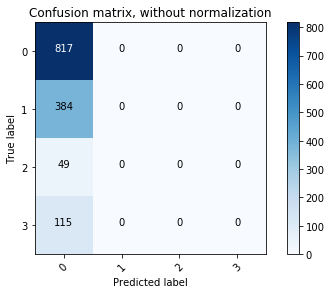

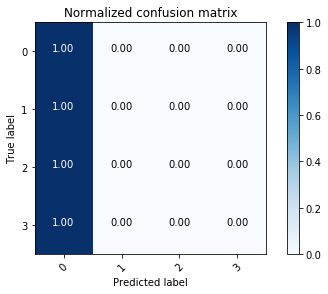

Confusion matrix, without normalization
[[801   0   0   0]
 [377   0   0   0]
 [ 56   0   0   0]
 [131   0   0   0]]
Normalized confusion matrix
[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]]


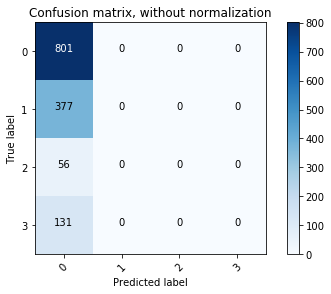

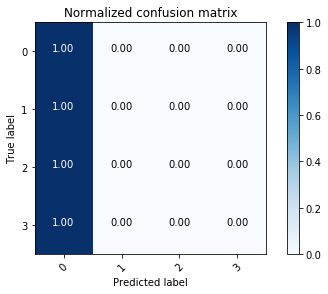

Confusion matrix, without normalization
[[807   0   0   0]
 [386   0   0   0]
 [ 50   0   0   0]
 [121   0   0   0]]
Normalized confusion matrix
[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]]


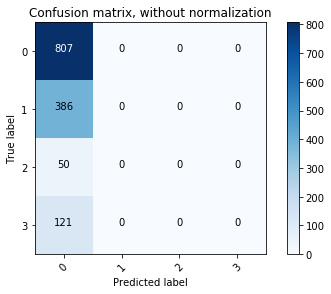

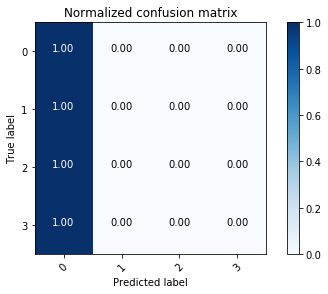

Confusion matrix, without normalization
[[801   0   0   0]
 [404   0   0   0]
 [ 45   0   0   0]
 [114   0   0   0]]
Normalized confusion matrix
[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]]


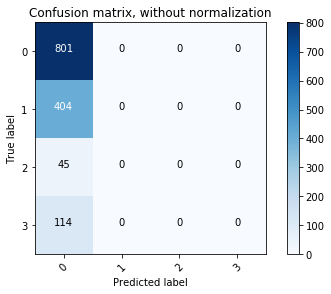

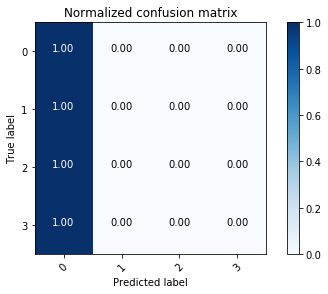

Confusion matrix, without normalization
[[814   0   0   0]
 [414   0   0   0]
 [ 27   0   0   0]
 [109   0   0   0]]
Normalized confusion matrix
[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]]


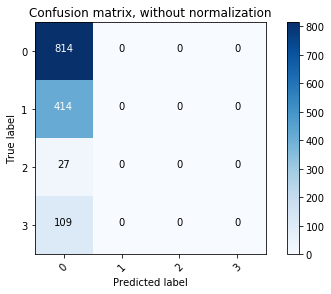

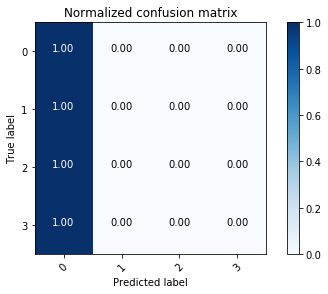

In [153]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=5)
for train_indices, test_indices in k_fold.split(X_meta_std):
    
    svc.fit(X_meta[train_indices], y_train[train_indices])
    y_pred = svc.predict(X_meta[test_indices])
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_train[test_indices], y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3],
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3], normalize=True,
                      title='Normalized confusion matrix')

    plt.show()    

Let's try to do a pipeline and use cross validation to tune the parameters.

In [6]:
cutter = Cut_burn_in(burn_in=1000, end_pt=9000)
fft_coef_extractor = Fft_coef_extractor(indices_coef=np.array(range(0, 1700)))
pca = PCA(150)
adaboost = AdaBoostClassifier(random_state=14)
svc = SVC(random_state=666)
pipeline = Pipeline(steps=[('cutter', cutter),
                           ('fft', fft_coef_extractor),
                           ('pca', pca)
                          ]
                   )

In [12]:
X_t2 = cutter.fit_transform(X_train)
X_t2 = fft_coef_extractor.fit_transform(X_t2)
pca.fit(X_t2)

/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


PCA(copy=True, iterated_power='auto', n_components=1700, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

It looks like 150 should be enough for PCA

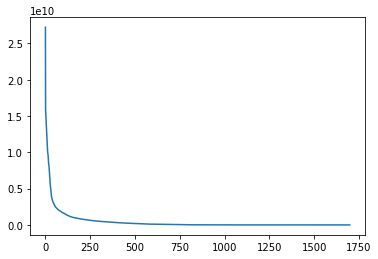

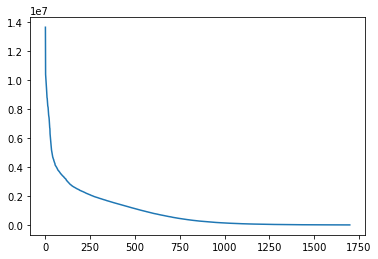

In [15]:
plt.plot(pca.explained_variance_)
plt.show()
plt.plot(pca.singular_values_)
plt.show()

In [7]:
X_t = pipeline.fit(X_train, y_train).transform(X_train)

/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


In [8]:
print(np.shape(X_t))

(6822, 150)


In [12]:
svc.set_params(kernel='poly', C=0.5, degree=4)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=4, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=666, shrinking=True,
  tol=0.001, verbose=False)

Let's use GridSearcCV

In [11]:
parameters_ada = {'n_estimators':[40, 100, 160],
                  'learning_rate':[1, 0.1, 0.01]}
parameters_svc = {'C':[1],
                  'class_weight':['balanced'],
                  'kernel':('rbf')}

In [ ]:
gscv = GridSearchCV(svc, parameters_svc, cv=3)
gscv.fit(X_t, y_train)

/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


In [155]:
print(gscv.cv_results_)
print(gscv.best_params_)
print(gscv.best_score_)

{'mean_fit_time': array([  9.48,  24.03,  38.44,   9.74,  24.74,  38.64,   9.58,  23.18,
        37.29]), 'std_fit_time': array([ 0.17,  0.1 ,  0.08,  0.06,  0.63,  0.39,  0.52,  0.27,  0.38]), 'mean_score_time': array([ 0.03,  0.08,  0.12,  0.03,  0.09,  0.12,  0.03,  0.07,  0.12]), 'std_score_time': array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.  ,  0.  ,  0.01]), 'param_learning_rate': masked_array(data = [1 1 1 0.1 0.1 0.1 0.01 0.01 0.01],
             mask = [False False False False False False False False False],
       fill_value = ?)
, 'param_n_estimators': masked_array(data = [40 100 160 40 100 160 40 100 160],
             mask = [False False False False False False False False False],
       fill_value = ?)
, 'params': [{'learning_rate': 1, 'n_estimators': 40}, {'learning_rate': 1, 'n_estimators': 100}, {'learning_rate': 1, 'n_estimators': 160}, {'learning_rate': 0.1, 'n_estimators': 40}, {'learning_rate': 0.1, 'n_estimators': 100}, {'learning_rate': 0.1, 'n_estimators

In [128]:
parameters2 = {'n_estimators':[20, 40, 60],
              'learning_rate':[0.01, 0.005, 0.001]}

In [131]:
gscv2 = GridSearchCV(adaboost, parameters2, cv=3)
gscv2.fit(X_t, y_train)

/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex v

/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex v

GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=14),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 40, 60], 'learning_rate': [0.01, 0.005, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [132]:
print(gscv2.best_params_)
print(gscv2.best_score_)

{'learning_rate': 0.001, 'n_estimators': 20}
0.593081207857


In [156]:
adaboost.set_params(learning_rate=0.1, n_estimators=100)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=100, random_state=14)

The next cell has been taken from:

http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py